### Import all necessary libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
#from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from sklearn.model_selection import train_test_split
import xgboost as xgb

from datetime import datetime, timedelta
from pandas.tseries.offsets import MonthEnd, BDay, Week
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.optimize import minimize
from statistics import mean

import pandas_ta as ta
import warnings
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import TruncatedSVD

# Suppress all warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
import sys
print(sys.version)


3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:37:07) [Clang 15.0.7 ]


### Evaluation Metrics
- MAE, RMSE, MASE

In [3]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Computes the Mean Absolute Scaled Error (MASE).
    
    Parameters:
    - y_true: True values.
    - y_pred: Predicted values.
    
    Returns:
    - MASE value.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    naive_forecast = np.roll(y_true, shift=1)  # Naïve forecast: previous value as the next
    naive_forecast[0] = y_true[0]  # First value remains the same to avoid shifting issues
    naive_mae = np.mean(np.abs(y_true - naive_forecast))  # Baseline error
    mase = np.mean(np.abs(y_true - y_pred)) / naive_mae if naive_mae != 0 else np.nan  # Avoid division by zero
    return mase


def calculate_metrics(y_true, y_pred, scaler):
    """
    Calculates RMSE and MAE evaluation metrics before and after inverse transformation.
    
    Parameters:
    - y_true: True values.
    - y_pred: Predicted values.
    - scaler: The target scaler used for inverse transformation.
    
    Returns:
    - RMSE and MAE values before and after inverse transformation.
    """
  
    #print(f"Scaled RMSE: {rmse_scaled}, Scaled MAE: {mae_scaled}")
    
    # Compute metrics after inverse transformation
    y_true_original = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    epsilon=1e-8
    rmse_original = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
    mae_original = mean_absolute_error(y_true_original, y_pred_original)
    mase_original = mean_absolute_scaled_error(y_true_original , y_pred_original) 
    
    #print(f"Original RMSE: {rmse_original}, Original MAE: {mae_original}")
    
    return rmse_original, mae_original, mase_original

### Functions from Data splitting, Data scaling, Hyp-params optimization, Full-model Training

In [4]:
# Step 1: Split the data
def split_data(data, max_lag, windows, train_start, train_end, test_start, test_end):
    """
    Splits the dataset into training and testing sets with lagged log returns, SMA features.
    Uses a unified 'windows' parameter for both SMA.
    """
    # Add seasonality features
    data['Month'] = data.index.month
    data['Weekday'] = data.index.weekday
    data['Quarter'] = data.index.quarter
    data['WeekOfYear'] = data.index.isocalendar().week
    
    # Generate lagged log return features
    for lag in range(1, max_lag + 1):
        data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)

    # Generate SMA features 
    for window in windows:
        data[f'SMA_{window}'] = data['Log_Return'].shift(1).rolling(window=window).mean()



    # Drop rows with NaN values due to lagging and SMA calculation
    data = data.dropna()

    # Extract feature columns
    feature_columns = [f'Lagged_Log_Return_{lag}' for lag in range(1, max_lag + 1)] + \
                      [f'SMA_{window}' for window in windows] + \
                      [ 'Month', 'Weekday', 'Quarter', 'WeekOfYear']
    
    # Extract features and target
    X = data[feature_columns].values
    y = data['Log_Return'].values

    # Create polynomial features
    poly_degree = 2
    poly = PolynomialFeatures(degree=poly_degree, interaction_only=True, include_bias=False)
    X_poly = poly.fit_transform(X)

    # Identify indices of original features in X_poly
    feature_names = poly.get_feature_names_out()
    original_feature_indices = [i for i, name in enumerate(feature_names) if name in feature_columns]
    
    # Extract original features from X_poly
    X_poly_original = X_poly[:, original_feature_indices]
    
    # Extract interaction terms (residuals)
    X_poly_residual = np.delete(X_poly, original_feature_indices, axis=1)

    # Apply Truncated SVD for dimensionality reduction
    svd_components = 40
    svd = TruncatedSVD(n_components=svd_components, random_state=42)
    X_svd = svd.fit_transform(X_poly_residual)

    # Combine original + SVD features
    X_combined = np.concatenate([X_poly_original, X_svd], axis=1)

    # Split data into training and testing sets
    train_size = int(len(data) * 0.75)
    X_train, X_test = X_combined[:train_size], X_combined[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, X_test, y_train, y_test, poly, svd, feature_columns


# Step 2: Scale the data
def scale_data(X_train, X_test, y_train, y_test):
    # Create scalers for features and target
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()
    
    # Scale features
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)
    
    # Scale target variable
    
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler


# Step 3: Model training with hyperparameter tuning and early stopping
def model_training(X_train_scaled, y_train_scaled):
    

    xgb_reg = xgb.XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        random_state=42,
        verbosity=0
    )

    param_space = {
        'n_estimators': Integer(600, 700),
        'max_depth': Integer(3, 6),                                 
        'learning_rate': Real(0.01, 0.1, prior='log-uniform'),    
        'subsample': Real(0.5, 0.8),
        'colsample_bytree': Real(0.6, 0.8),                         
        'colsample_bylevel': Real(0.6, 0.8),
        'colsample_bynode': Real(0.6, 0.8),
        'gamma': Real(0.01, 5.0, prior='log-uniform'),                                  
        'reg_alpha': Real(0.00001, 0.1, prior='log-uniform'),
        'reg_lambda': Real(0.01, 10.0, prior='log-uniform'), #5.0       
        'min_child_weight': Integer(10, 50),                        
        'max_delta_step': Integer(1, 5),                            
    }

    # Bayesian search with the new parameter space
    bayes_search = BayesSearchCV(
        estimator=xgb_reg,
        search_spaces=param_space,
        n_iter=30,
        cv=5,                                    # Increased CV for robust validation
        scoring='neg_mean_absolute_error',
        random_state=42,
        n_jobs=-1,
        fit_params={  # Pass early stopping parameters here
            "early_stopping_rounds": 40,
            "verbose": False
        }
    )

    # Fit with early stopping
    bayes_search.fit(X_train_scaled, y_train_scaled.ravel())

    best_model = bayes_search.best_estimator_
    best_params = bayes_search.best_params_

    print("Best Model Parameters:")
    print(best_params)
    

    return best_model, best_params


def train_final_model(data, max_lag, windows,feature_scaler, target_scaler, best_params):
    X_full, _, y_full, _ , _, _, _ = split_data(data, max_lag, windows, "2000-01-01", "2021-12-31", None, None)
    X_full_scaled = feature_scaler.transform(X_full)
    y_full_scaled = target_scaler.transform(y_full.reshape(-1, 1))

    #  Check if `best_params` are properly set
    if best_params is None:
        raise ValueError("Error: No best parameters found for final model training.")

    
    # Create and train the XGBoost regressor with the best hyperparameters
    final_model = xgb.XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        random_state=42,
        verbosity=0,
        **best_params  # Unpack the best parameters into the model constructor
    )
    final_model.fit(X_full_scaled, y_full_scaled.ravel())

    #  Ensure the model is trained properly
    if final_model is None:
        raise ValueError("Final model training failed!")

    return final_model, feature_scaler, target_scaler  # Must return the trained model

### Method for future days forecasting

In [5]:
def forecast_future(data, model, feature_scaler, target_scaler,poly, svd, feature_cols, max_lag, windows, start_date, end_date):
    """
    Recursively forecasts future log returns using lag, SMA, and time-based features.
    Forecasted values are appended back into the dataset to allow rolling feature generation.
    """
    forecast_dates = pd.date_range(start=start_date, end=end_date, freq='B')  # Business days only
    data = data.copy()

    # Ensure only necessary column is there and index is sorted
    data = data[['Log_Return']].copy()
    data = data.sort_index()

    forecasted_values = []

    for forecast_date in forecast_dates:
        # Dynamically add forecast row placeholder
        if forecast_date not in data.index:
            data.loc[forecast_date] = np.nan

        # Get the index position of forecast_date
        idx = data.index.get_loc(forecast_date)

        # Create a new feature row
        new_row = pd.DataFrame(index=[forecast_date])

        # Seasonality/time features using your suggested methods
        new_row['Month'] = forecast_date.month
        new_row['Weekday'] = forecast_date.weekday()
        new_row['Quarter'] = forecast_date.quarter
        new_row['WeekOfYear'] = forecast_date.isocalendar().week

        # Lag features
        for lag in range(1, max_lag + 1):
            lag_idx = idx - lag
            if lag_idx >= 0:
                new_row[f'Lagged_Log_Return_{lag}'] = data.iloc[lag_idx]['Log_Return']
            else:
                new_row[f'Lagged_Log_Return_{lag}'] = np.nan

        # SMA features
        for window in windows:
            start_idx = idx - window
            if start_idx >= 0:
                sma_vals = data.iloc[start_idx:idx]['Log_Return'].dropna()
                new_row[f'SMA_{window}'] = sma_vals.mean() if len(sma_vals) == window else np.nan
            else:
                new_row[f'SMA_{window}'] = np.nan

        # If any feature is NaN, skip this forecast
        if new_row.isnull().any(axis=1).values[0]:
            forecasted_values.append(np.nan)
            continue

        # Feature order must match training
        feature_columns = [f'Lagged_Log_Return_{lag}' for lag in range(1, max_lag + 1)] + \
                          [f'SMA_{w}' for w in windows] + ['Month', 'Weekday', 'Quarter', 'WeekOfYear']

        # Transform features
        #X = feature_scaler.transform(new_row[feature_columns])

        input_features_poly = poly.transform(new_row[feature_columns])
        
        # Extract Original Features Explicitly
        feature_names = poly.get_feature_names_out()
        original_feature_indices = [i for i, name in enumerate(feature_names) if name in feature_cols]
        
        # Extract original features directly
        input_features_original = input_features_poly[:, original_feature_indices]
        
        # Extract interaction terms (residuals)
        input_features_residual = np.delete(input_features_poly, original_feature_indices, axis=1)
        
        # Apply SVD Transformation on Residuals
        input_features_svd = svd.transform(input_features_residual)
        
        # Combine Original Features + SVD Features
        input_features_combined = np.concatenate([input_features_original, input_features_svd], axis=1)
        
        # Scale the combined features
        X = feature_scaler.transform(input_features_combined)
        
        # Predict and inverse transform
        y_pred_scaled = model.predict(X)[0]
        #y_pred_original = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()[0]
        y_pred_original = target_scaler.inverse_transform([[y_pred_scaled]])[0][0]

        


        # Add forecasted value to the data for future feature generation
        data.loc[forecast_date, 'Log_Return'] = y_pred_original

        # Store and append prediction to forecasted values
        forecasted_values.append(y_pred_original)
        
    # Return DataFrame with forecasted values
    forecast_df = pd.DataFrame({'Forecasted_Log_Return': forecasted_values}, index=forecast_dates)
    return forecast_df


In [6]:
def plot_forecasted_returns(df_forecast):
    """
    Plots the forecasted log returns over time.
    
    Parameters:
    df_forecast (pd.DataFrame): DataFrame containing 'Date' and 'Forecasted_Log_Return' columns.
    """

    df_forecast.index = pd.to_datetime(df_forecast.index)
    
    # Plot the forecasted returns
    plt.figure(figsize=(12, 6))
    plt.plot(df_forecast.index, df_forecast["Forecasted_Log_Return"], color='orange', linestyle='-', label="Forecasted Returns")
    
    plt.title("Forecasted Log Returns for 2022")
    plt.xlabel("Date")
    plt.ylabel("Forecasted Log Return")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    # Show the plot
    plt.show()

### Grouping forecast into monthly and weekly horizons

In [7]:
def group_forecasts(forecast_df, year):
    """
    Groups the forecasted log returns month-wise and week-wise based on the given year.
    
    Parameters:
    - forecast_df: DataFrame with forecasted log returns indexed by date.
    - year: Year for which weeks should be grouped.
    
    Returns:
    - Dictionary with forecasted log returns per month and per week as lists.
    """
    forecast_df['Month'] = forecast_df.index.to_period('M')
    forecast_df['Week'] = forecast_df.index.to_period('W-SUN')  # Ensure weeks align with trading days
    
    grouped_month_forecast = {f"forecast_predictions_df_{i+1}m": values for i, (key, values) in enumerate(forecast_df.groupby('Month')['Forecasted_Log_Return'].apply(list).items())}
    grouped_week_forecast = {f"forecast_predictions_df_{i+1}w": values for i, (key, values) in enumerate(forecast_df[forecast_df.index.year == year].groupby(pd.Grouper(freq='W-FRI'))['Forecasted_Log_Return'].apply(list).items())}
    
    return grouped_month_forecast, grouped_week_forecast


### Workflow which executes all the above methods

In [8]:
# Step 7: Main Function
def main(data):
    max_lag = 80
    train_start, train_end = "2000-01-01", "2014-12-31"
    test_start, test_end = "2015-01-01", "2022-01-01"
    windows = [5,10,50]
    # Split Data for Evaluation
    X_train, X_test, y_train, y_test, poly, svd, feature_cols = split_data(data, max_lag, windows, train_start, train_end, test_start, test_end)

    # Scale Data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler = scale_data(X_train, X_test, y_train, y_test)

    start_time = time.time()    
    best_model, best_params = model_training(X_train_scaled, y_train_scaled)
    end_time = time.time()
    computaton_time = end_time - start_time
    print(f"Computation Time: {computaton_time:.2f} seconds")
    
    # Generate Predictions
    train_predictions_scaled = best_model.predict(X_train_scaled)
    test_predictions_scaled = best_model.predict(X_test_scaled)
        
    # Evaluate Train-Test Performance
    train_rmse, train_mae, train_mase = calculate_metrics(y_train_scaled, train_predictions_scaled, target_scaler)
    test_rmse, test_mae, test_mase = calculate_metrics(y_test_scaled, test_predictions_scaled, target_scaler)

    print(f"Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}, Train MASE : {train_mase:.4f} ")
    print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}, Test MASE: {test_mase:.4f} ")
    # Step 6: Compute evaluation metrics
    
    model_metrics={
                "training_set":{
                    "mae" : train_mae,
                    "rmse" : train_rmse,
                    "mase" : train_mase
                },
                "test_set":{
                    "mae" : test_mae,
                    "rmse" : test_rmse,
                    "mase" : test_mase
                },
                "time":computaton_time
                
        }
    
    
    # Train Final Model on Full Dataset (`2000-2021`)
    final_model, feature_scaler, target_scaler = train_final_model(data, max_lag, windows, feature_scaler, target_scaler, best_params)

    # Forecast Future (`2022`)
    future_predictions = forecast_future(data, final_model, feature_scaler, target_scaler, poly, svd, feature_cols, max_lag, windows, start_date="2022-01-01", end_date="2022-12-31" )

    print("Future Predictions:")
    print(future_predictions)

    return final_model, future_predictions, model_metrics

### Method to trigger the above worflow with input tickers and data loading method

Processing SMH...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Best Model Parameters:
OrderedDict([('colsample_bylevel', 0.6174145232765307), ('colsample_bynode', 0.6708854850213528), ('colsample_bytree', 0.6235812265927417), ('gamma', 4.999999999999999), ('learning_rate', 0.01), ('max_delta_step', 3), ('max_depth', 4), ('min_child_weight', 25), ('n_estimators', 645), ('reg_alpha', 0.014614715058727747), ('reg_lambda', 10.0), ('subsample', 0.5396331821304643)])
Computation Time: 23.88 seconds
Train RMSE: 0.0205, Train MAE: 0.0145, Train MASE : 0.6540 
Test RMSE: 0.0190, Test MAE: 0.0134, Test MASE: 0.6698 
Future Predictions:
            Forecasted_Log_Return
2022-01-03               0.000424
2022-01-04               0.000864
2022-01-05               0.000925
2022-01-06               0.001164
2022-01-07               0.001023
2022-01-10               0.000340
2022-01-11               0.000400
2022-01-12               0.000500
2022-01-13               0.000715
2022-01-14              -0.000016
2022-01-17               0.000121
2022-01-18           

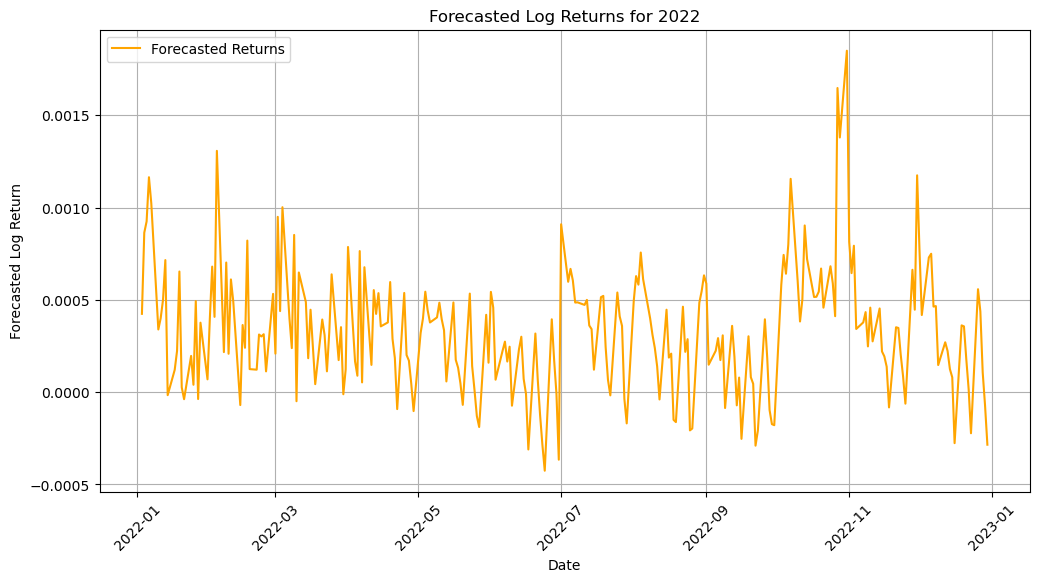

Processing SOXX...


[*********************100%***********************]  1 of 1 completed


Best Model Parameters:
OrderedDict([('colsample_bylevel', 0.6), ('colsample_bynode', 0.6853668437463125), ('colsample_bytree', 0.6), ('gamma', 4.999999999999999), ('learning_rate', 0.01), ('max_delta_step', 1), ('max_depth', 3), ('min_child_weight', 50), ('n_estimators', 600), ('reg_alpha', 0.1), ('reg_lambda', 10.0), ('subsample', 0.5531670789057213)])
Computation Time: 22.04 seconds
Train RMSE: 0.0191, Train MAE: 0.0139, Train MASE : 0.6780 
Test RMSE: 0.0196, Test MAE: 0.0137, Test MASE: 0.6722 
Future Predictions:
            Forecasted_Log_Return
2022-01-03           8.306810e-04
2022-01-04           7.500100e-04
2022-01-05           4.795923e-04
2022-01-06           1.394051e-03
2022-01-07           9.848233e-04
2022-01-10           6.357960e-04
2022-01-11           7.448008e-04
2022-01-12           2.319803e-04
2022-01-13           9.784275e-04
2022-01-14           5.999499e-04
2022-01-17           2.919632e-04
2022-01-18           5.568494e-04
2022-01-19          -2.223398e-04


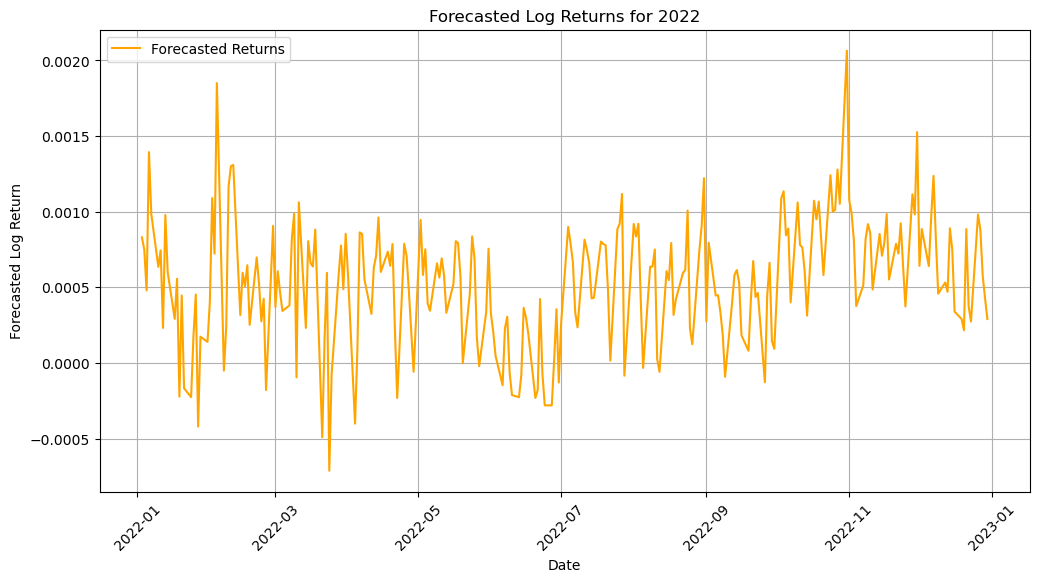

Processing PSI...


[*********************100%***********************]  1 of 1 completed


Best Model Parameters:
OrderedDict([('colsample_bylevel', 0.6), ('colsample_bynode', 0.6), ('colsample_bytree', 0.6), ('gamma', 4.999999999999999), ('learning_rate', 0.01), ('max_delta_step', 1), ('max_depth', 3), ('min_child_weight', 10), ('n_estimators', 600), ('reg_alpha', 0.1), ('reg_lambda', 0.01), ('subsample', 0.8)])
Computation Time: 20.67 seconds
Train RMSE: 0.0162, Train MAE: 0.0122, Train MASE : 0.6608 
Test RMSE: 0.0221, Test MAE: 0.0158, Test MASE: 0.6789 
Future Predictions:
            Forecasted_Log_Return
2022-01-03               0.000893
2022-01-04               0.000645
2022-01-05               0.000834
2022-01-06               0.000898
2022-01-07               0.000530
2022-01-10               0.000958
2022-01-11               0.000672
2022-01-12               0.000514
2022-01-13               0.000794
2022-01-14               0.000424
2022-01-17               0.000318
2022-01-18               0.000955
2022-01-19               0.001056
2022-01-20               0.000

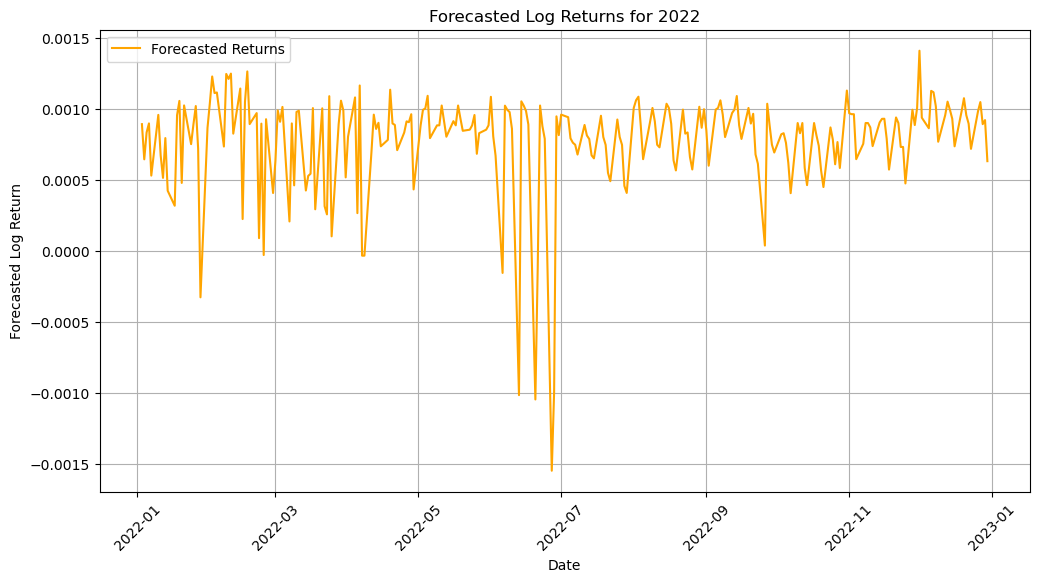

Processing XSD...


[*********************100%***********************]  1 of 1 completed


Best Model Parameters:
OrderedDict([('colsample_bylevel', 0.6), ('colsample_bynode', 0.6), ('colsample_bytree', 0.6), ('gamma', 4.999999999999999), ('learning_rate', 0.01), ('max_delta_step', 5), ('max_depth', 3), ('min_child_weight', 50), ('n_estimators', 600), ('reg_alpha', 0.1), ('reg_lambda', 0.2555472050061139), ('subsample', 0.8)])
Computation Time: 20.45 seconds
Train RMSE: 0.0173, Train MAE: 0.0128, Train MASE : 0.6751 
Test RMSE: 0.0218, Test MAE: 0.0157, Test MASE: 0.6772 
Future Predictions:
            Forecasted_Log_Return
2022-01-03               0.000605
2022-01-04               0.000495
2022-01-05               0.000621
2022-01-06               0.000715
2022-01-07               0.000704
2022-01-10               0.000464
2022-01-11               0.000639
2022-01-12               0.000618
2022-01-13               0.000758
2022-01-14               0.000676
2022-01-17               0.000484
2022-01-18               0.000583
2022-01-19               0.000671
2022-01-20      

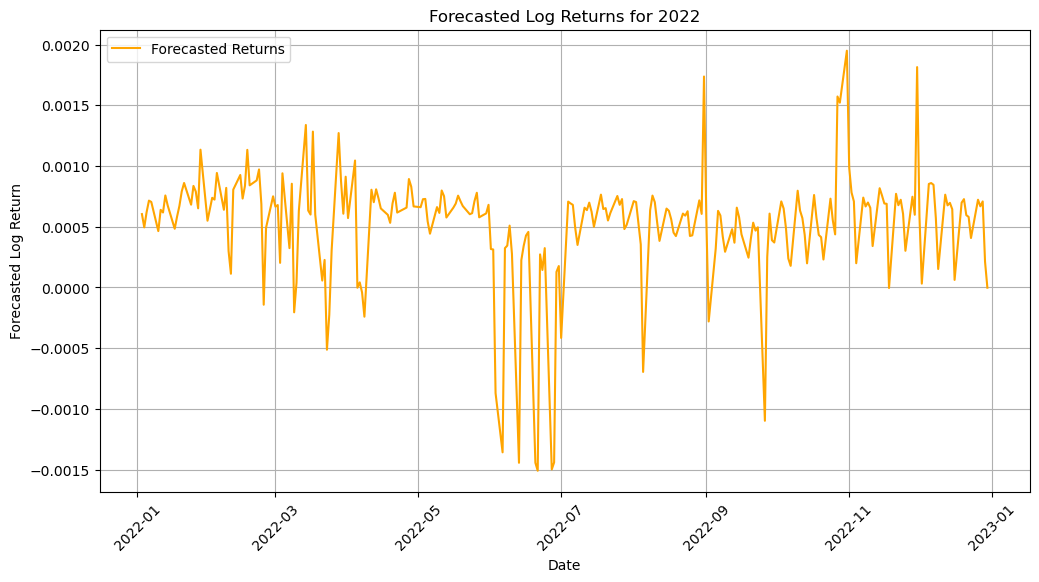

Processing IYW...


[*********************100%***********************]  1 of 1 completed


Best Model Parameters:
OrderedDict([('colsample_bylevel', 0.6373080889562838), ('colsample_bynode', 0.8), ('colsample_bytree', 0.7469425918388777), ('gamma', 4.999999999999999), ('learning_rate', 0.01), ('max_delta_step', 2), ('max_depth', 3), ('min_child_weight', 22), ('n_estimators', 639), ('reg_alpha', 0.0005316036435598167), ('reg_lambda', 0.09127526352109407), ('subsample', 0.6823824981210063)])
Computation Time: 24.16 seconds
Train RMSE: 0.0161, Train MAE: 0.0111, Train MASE : 0.6499 
Test RMSE: 0.0153, Test MAE: 0.0100, Test MASE: 0.6704 
Future Predictions:
            Forecasted_Log_Return
2022-01-03           2.176301e-03
2022-01-04           1.737261e-03
2022-01-05           1.785154e-03
2022-01-06           2.108523e-03
2022-01-07          -1.768960e-05
2022-01-10           5.463455e-04
2022-01-11           7.589805e-04
2022-01-12           4.685249e-05
2022-01-13           3.089879e-04
2022-01-14          -3.172234e-04
2022-01-17           2.730318e-04
2022-01-18          

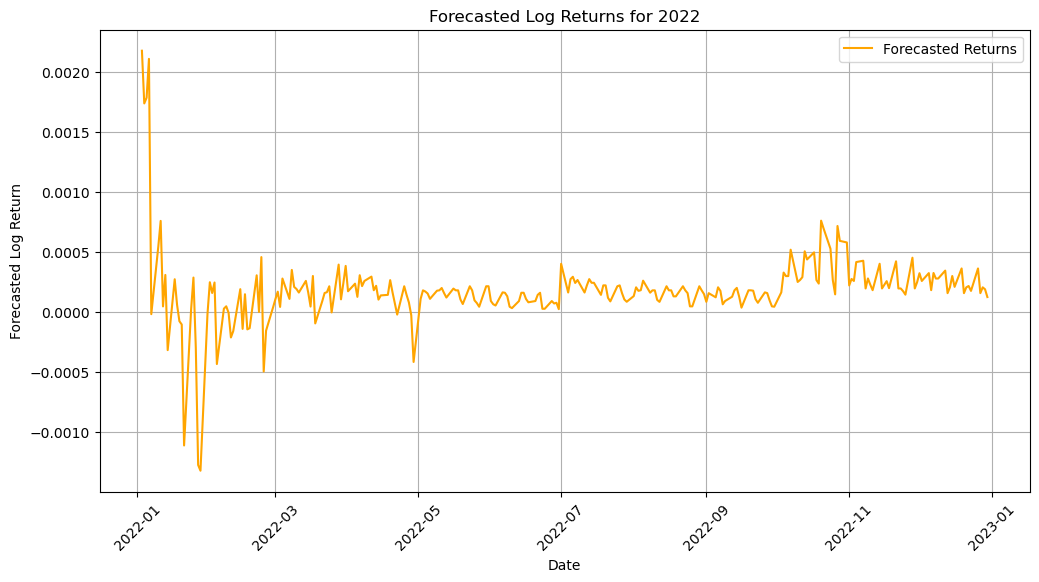

Processing XLK...


[*********************100%***********************]  1 of 1 completed


Best Model Parameters:
OrderedDict([('colsample_bylevel', 0.8), ('colsample_bynode', 0.8), ('colsample_bytree', 0.6492372230024543), ('gamma', 4.999999999999999), ('learning_rate', 0.01), ('max_delta_step', 3), ('max_depth', 3), ('min_child_weight', 10), ('n_estimators', 600), ('reg_alpha', 0.1), ('reg_lambda', 10.0), ('subsample', 0.5)])
Computation Time: 22.09 seconds
Train RMSE: 0.0151, Train MAE: 0.0104, Train MASE : 0.6466 
Test RMSE: 0.0151, Test MAE: 0.0097, Test MASE: 0.6697 
Future Predictions:
            Forecasted_Log_Return
2022-01-03               0.001763
2022-01-04               0.001852
2022-01-05               0.001690
2022-01-06               0.001879
2022-01-07               0.000436
2022-01-10               0.000193
2022-01-11               0.000535
2022-01-12               0.000279
2022-01-13               0.000243
2022-01-14              -0.000009
2022-01-17               0.000289
2022-01-18               0.000245
2022-01-19              -0.000149
2022-01-20     

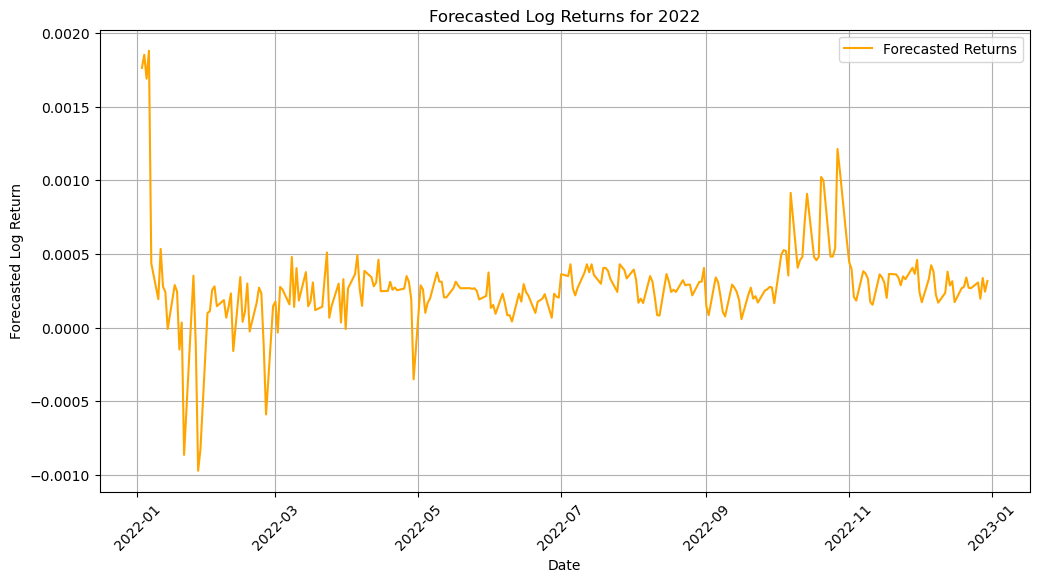

Processing VGT...


[*********************100%***********************]  1 of 1 completed


Best Model Parameters:
OrderedDict([('colsample_bylevel', 0.8), ('colsample_bynode', 0.6), ('colsample_bytree', 0.8), ('gamma', 4.999999999999999), ('learning_rate', 0.01), ('max_delta_step', 5), ('max_depth', 3), ('min_child_weight', 10), ('n_estimators', 600), ('reg_alpha', 1e-05), ('reg_lambda', 10.0), ('subsample', 0.8)])
Computation Time: 20.59 seconds
Train RMSE: 0.0117, Train MAE: 0.0084, Train MASE : 0.6504 
Test RMSE: 0.0163, Test MAE: 0.0108, Test MASE: 0.6700 
Future Predictions:
            Forecasted_Log_Return
2022-01-03               0.000342
2022-01-04               0.000287
2022-01-05               0.000219
2022-01-06               0.000348
2022-01-07               0.000259
2022-01-10               0.000369
2022-01-11               0.000428
2022-01-12               0.000226
2022-01-13               0.000136
2022-01-14              -0.000064
2022-01-17               0.000142
2022-01-18               0.000257
2022-01-19              -0.000154
2022-01-20              -0.0

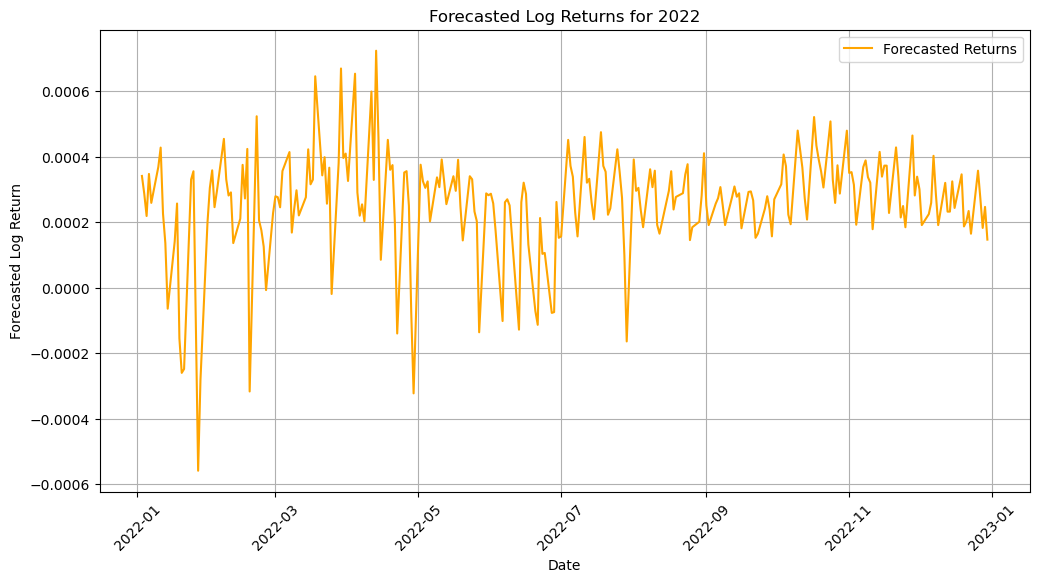

Processing QQQ...


[*********************100%***********************]  1 of 1 completed


Best Model Parameters:
OrderedDict([('colsample_bylevel', 0.7476695916348343), ('colsample_bynode', 0.6), ('colsample_bytree', 0.6), ('gamma', 4.999999999999999), ('learning_rate', 0.01), ('max_delta_step', 5), ('max_depth', 3), ('min_child_weight', 50), ('n_estimators', 688), ('reg_alpha', 1e-05), ('reg_lambda', 10.0), ('subsample', 0.8)])
Computation Time: 24.32 seconds
Train RMSE: 0.0164, Train MAE: 0.0112, Train MASE : 0.6521 
Test RMSE: 0.0139, Test MAE: 0.0090, Test MASE: 0.6756 
Future Predictions:
            Forecasted_Log_Return
2022-01-03               0.000295
2022-01-04               0.000302
2022-01-05               0.000302
2022-01-06               0.000290
2022-01-07               0.000279
2022-01-10               0.000224
2022-01-11               0.000323
2022-01-12               0.000264
2022-01-13               0.000100
2022-01-14               0.000075
2022-01-17               0.000213
2022-01-18               0.000123
2022-01-19               0.000131
2022-01-20   

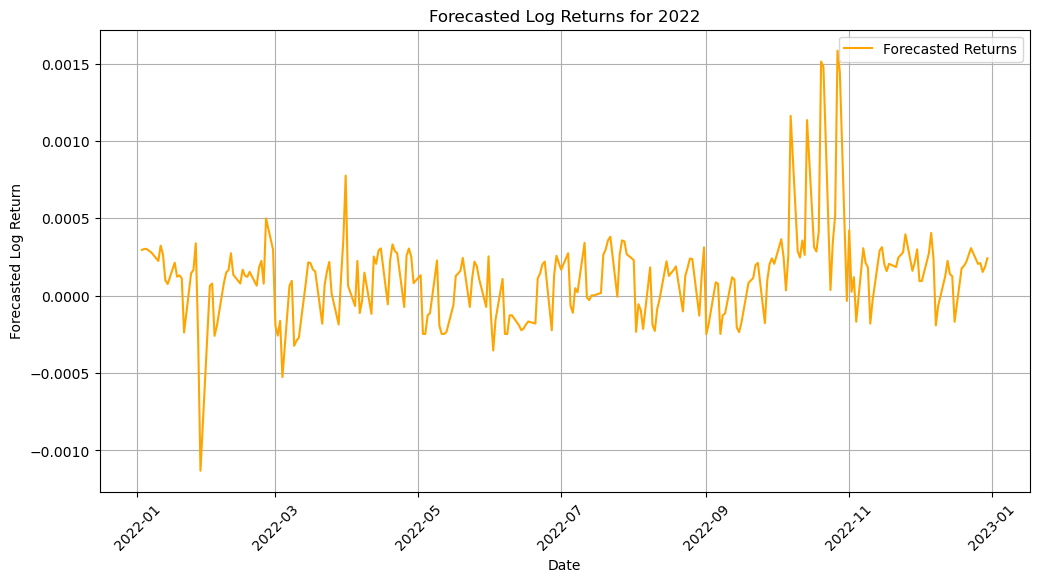

Processing IGM...


[*********************100%***********************]  1 of 1 completed


Best Model Parameters:
OrderedDict([('colsample_bylevel', 0.6246657218871497), ('colsample_bynode', 0.6035303380555463), ('colsample_bytree', 0.6), ('gamma', 0.030288092671438074), ('learning_rate', 0.011027247151516767), ('max_delta_step', 5), ('max_depth', 3), ('min_child_weight', 50), ('n_estimators', 600), ('reg_alpha', 1e-05), ('reg_lambda', 1.534242429364232), ('subsample', 0.5748687785110828)])
Computation Time: 21.40 seconds
Train RMSE: 0.0143, Train MAE: 0.0101, Train MASE : 0.6630 
Test RMSE: 0.0149, Test MAE: 0.0099, Test MASE: 0.6751 
Future Predictions:
            Forecasted_Log_Return
2022-01-03               0.000166
2022-01-04               0.000267
2022-01-05               0.000103
2022-01-06               0.000245
2022-01-07               0.000407
2022-01-10               0.000225
2022-01-11               0.000195
2022-01-12               0.000208
2022-01-13               0.000105
2022-01-14              -0.000330
2022-01-17              -0.000159
2022-01-18         

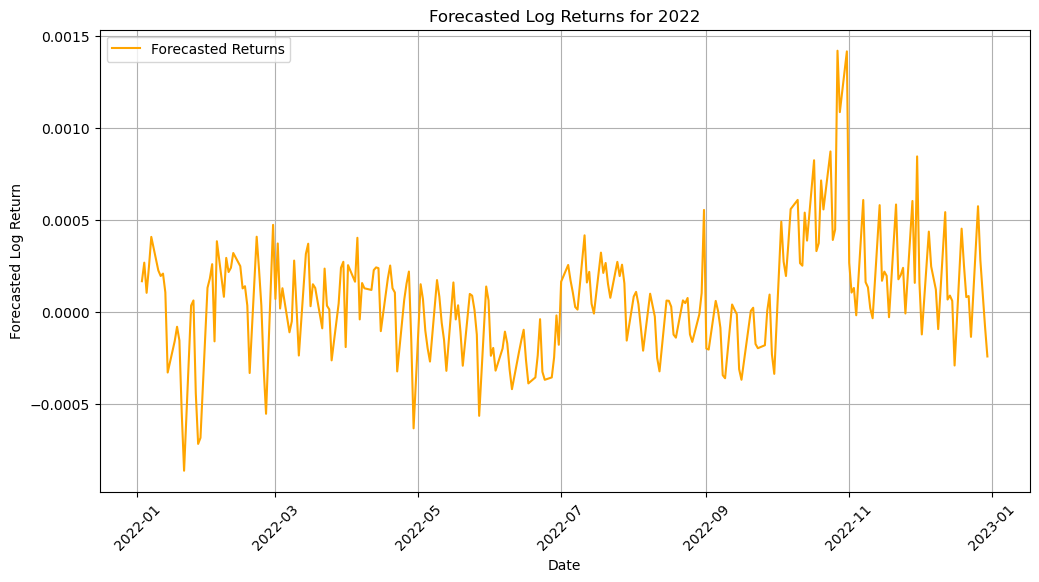

Processing IXN...


[*********************100%***********************]  1 of 1 completed


Best Model Parameters:
OrderedDict([('colsample_bylevel', 0.8), ('colsample_bynode', 0.6), ('colsample_bytree', 0.6), ('gamma', 0.01), ('learning_rate', 0.01), ('max_delta_step', 5), ('max_depth', 3), ('min_child_weight', 10), ('n_estimators', 700), ('reg_alpha', 0.1), ('reg_lambda', 10.0), ('subsample', 0.5)])
Computation Time: 21.91 seconds
Train RMSE: 0.0130, Train MAE: 0.0091, Train MASE : 0.6401 
Test RMSE: 0.0156, Test MAE: 0.0102, Test MASE: 0.6781 
Future Predictions:
            Forecasted_Log_Return
2022-01-03               0.000228
2022-01-04               0.000276
2022-01-05               0.000283
2022-01-06               0.000093
2022-01-07              -0.000014
2022-01-10              -0.000036
2022-01-11               0.000282
2022-01-12               0.000192
2022-01-13               0.000142
2022-01-14               0.000132
2022-01-17               0.000143
2022-01-18               0.000294
2022-01-19              -0.000026
2022-01-20              -0.000067
2022-01-2

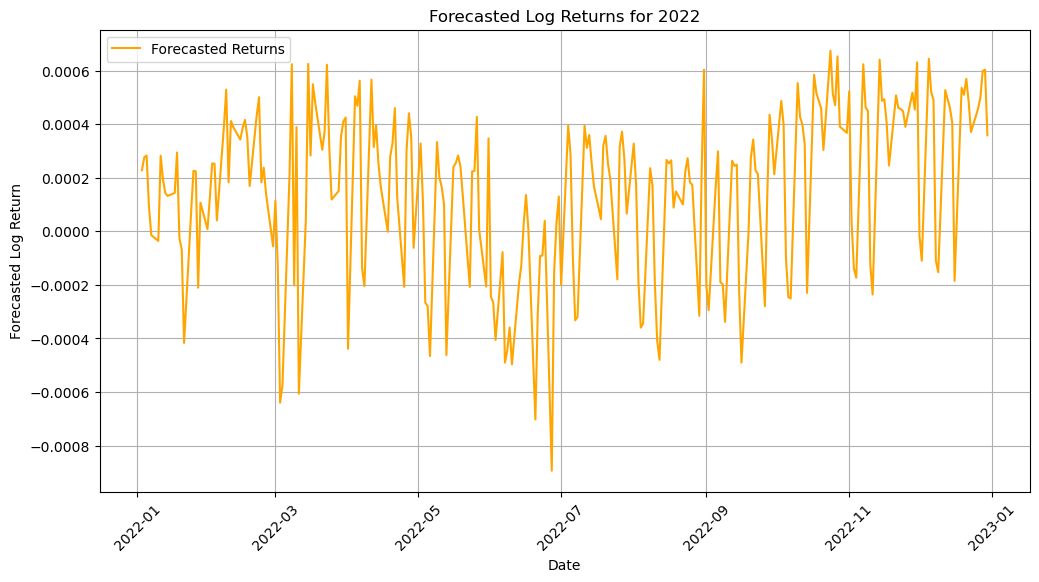

In [9]:
def run_workflow(tickers):
    """
    Runs the workflow for multiple stock tickers.
    """
    results = {}
    
    for ticker in tickers:
        print(f"Processing {ticker}...")
        
        # Step 1: Download data
        data = yf.download(ticker, start="2000-01-01", end="2021-12-31")
        data.columns = data.columns.get_level_values(0)
        data = data.drop(columns={'High', 'Low', 'Open', 'Volume'})
        
        # Step 2: Compute log returns
        data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
        
        # Step 3: Drop NaN values
        data = data.dropna()
        
        # Step 4: Ensure index is datetime
        data.index = pd.to_datetime(data.index)
        
        # Step 5: Run the main function
        final_model, future_predictions, model_metrics = main(data)
        
        plot_forecasted_returns(future_predictions)
        # Step 6: Group forecasted returns month-wise and week-wise for 2022
        monthly_forecasts, weekly_forecasts = group_forecasts(future_predictions, year=2022)
        
        # Step 7: Store results in a dictionary
        results[ticker] = {
            #"final_model": final_model,
            #"future_predictions": future_predictions,
            "monthly_forecast_results": monthly_forecasts,
            "weekly_forecast_results": weekly_forecasts,
            "model_metrics": model_metrics
        }
    
    return results

# List of tickers to process
tickers = ['SMH', 'SOXX', 'PSI', 'XSD', 'IYW', 'XLK', 'VGT', 'QQQ', 'IGM', 'IXN']


# Execute the workflow for multiple tickers
results = run_workflow(tickers)


### Method to define overview of the metrics and plot the same

Overall mean Training MAE: 0.0114
Overall mean Test MAE: 0.0118
Overall mean Training RMSE: 0.0160
Overall mean Test RMSE: 0.0174
Overall mean Training MASE: 0.66
Overall mean Test MASE: 0.67
Total time elapsed to run the model: 221.52 seconds
Average time consumed by model to train on an ETF: 22.15 seconds


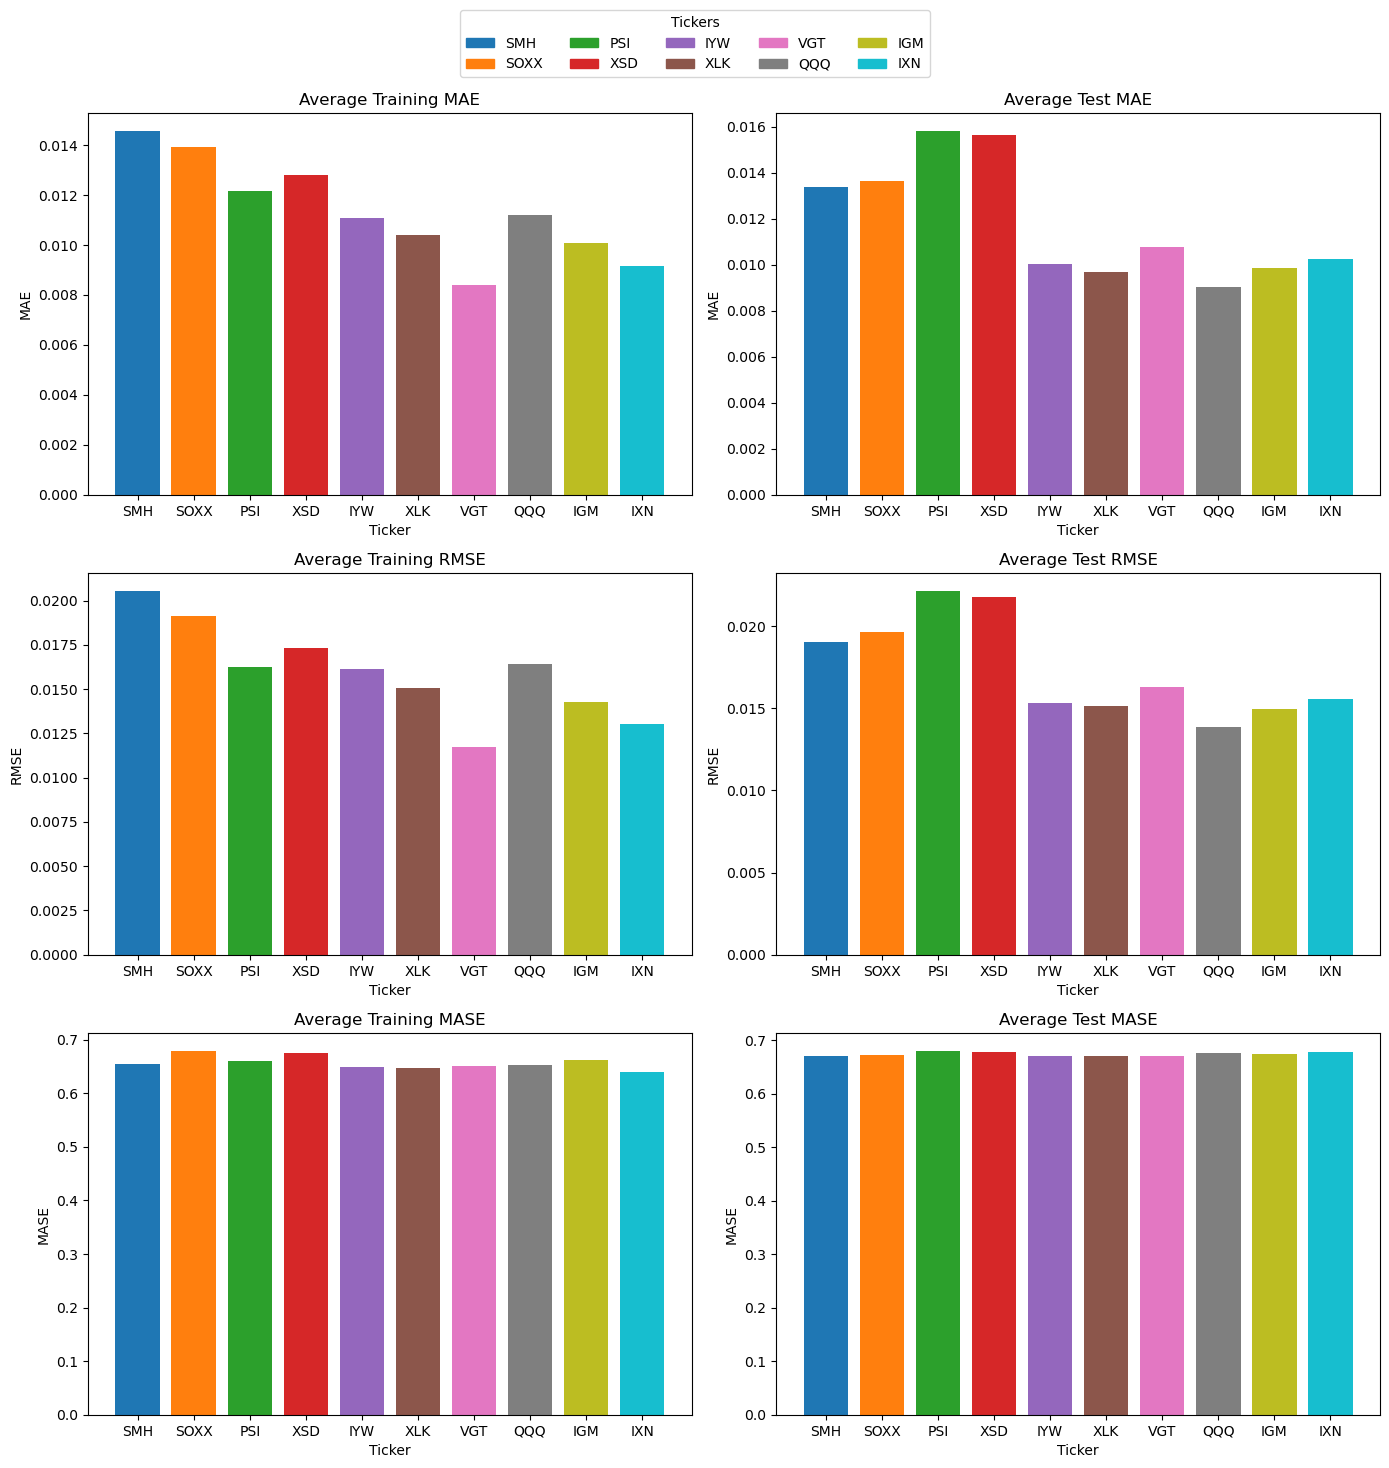

In [10]:
def plot_model_metrics(tickers, results):
    """
    Plots model performance metrics (MAE, RMSE, and MASE) for training and test sets.
    
    Parameters:
    - tickers: List of tickers.
    - results: Dictionary containing model metrics for each ticker.
    """
    
    # --- 1. Gather metrics from 'results' for each ticker ---
    avg_training_mae = []
    avg_test_mae = []
    avg_training_rmse = []
    avg_test_rmse = []
    avg_training_mase = []
    avg_test_mase = []

    computation_time = []
    
    for ticker in tickers:
        model_metrics = results[ticker].get("model_metrics", {})
        
        train_set = model_metrics.get("training_set", {})
        test_set = model_metrics.get("test_set", {})
        
        avg_training_mae.append(train_set.get("mae", float('nan')))
        avg_test_mae.append(test_set.get("mae", float('nan')))
        avg_training_rmse.append(train_set.get("rmse", float('nan')))
        avg_test_rmse.append(test_set.get("rmse", float('nan')))
        avg_training_mase.append(train_set.get("mase", float('nan')))
        avg_test_mase.append(test_set.get("mase", float('nan')))

        computation_time.append(model_metrics.get("time", float('nan'))) 
    
    # Print global averages
    print(f"Overall mean Training MAE: {mean(avg_training_mae):.4f}")
    print(f"Overall mean Test MAE: {mean(avg_test_mae):.4f}")
    print(f"Overall mean Training RMSE: {mean(avg_training_rmse):.4f}")
    print(f"Overall mean Test RMSE: {mean(avg_test_rmse):.4f}")
    print(f"Overall mean Training MASE: {mean(avg_training_mase):.2f}")
    print(f"Overall mean Test MASE: {mean(avg_test_mase):.2f}")
    print(f"Total time elapsed to run the model: {sum(computation_time):.2f} seconds")
    print(f"Average time consumed by model to train on an ETF: {mean(computation_time):.2f} seconds")

    # --- 2. Define a color palette ---
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]

    # --- 3. Set up a 3×2 subplot grid ---
    fig, axs = plt.subplots(3, 2, figsize=(14, 15))
    x_positions = range(len(tickers))  # One position per ticker

    # --- Subplot 1: Average Training MAE ---
    ax = axs[0, 0]
    ax.bar(x_positions, avg_training_mae, color=colors[:len(tickers)])
    ax.set_title("Average Training MAE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MAE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 2: Average Test MAE ---
    ax = axs[0, 1]
    ax.bar(x_positions, avg_test_mae, color=colors[:len(tickers)])
    ax.set_title("Average Test MAE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MAE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 3: Average Training RMSE ---
    ax = axs[1, 0]
    ax.bar(x_positions, avg_training_rmse, color=colors[:len(tickers)])
    ax.set_title("Average Training RMSE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("RMSE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 4: Average Test RMSE ---
    ax = axs[1, 1]
    ax.bar(x_positions, avg_test_rmse, color=colors[:len(tickers)])
    ax.set_title("Average Test RMSE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("RMSE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 5: Average Training MASE ---
    ax = axs[2, 0]
    ax.bar(x_positions, avg_training_mase, color=colors[:len(tickers)])
    ax.set_title("Average Training MASE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MASE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 6: Average Test MASE ---
    ax = axs[2, 1]
    ax.bar(x_positions, avg_test_mase, color=colors[:len(tickers)])
    ax.set_title("Average Test MASE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MASE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- 4. Create a single legend for the entire figure ---
    legend_handles = [
        mpatches.Patch(color=c, label=ticker)
        for c, ticker in zip(colors[:len(tickers)], tickers)
    ]
    plt.tight_layout(rect=[0, 0, 1, 0.93])

    fig.legend(
        handles=legend_handles,
        title="Tickers",
        loc="upper center",
        bbox_to_anchor=(0.5, 0.98),
        ncol=min(5, len(tickers))
    )

    plt.show()

plot_model_metrics(tickers, results)

### Computation of Perfomance Metrics
- Rachev, Sharpe and Sortino Ratio
- Volatility clustering

In [11]:
def calculate_sharpe_ratio(returns, risk_free_rate_annual=0.1):
    """
    Diagnostic Sharpe Ratio function to print intermediate steps and identify issues.
    
    Parameters:
    - returns (numpy array or list): Array of daily log returns (already partitioned).
    - risk_free_rate_annual (float): Annualized risk-free rate. Default is 3% (0.03).
    
    Returns:
    - sharpe_ratio (float): The Sharpe Ratio.
    """
    # Convert list to numpy array if necessary
    returns = np.array(returns)
    
    # Adjust risk-free rate for daily frequency
    risk_free_rate_daily = (1 + risk_free_rate_annual) ** (1 / 252) - 1
    
    # Calculate excess returns using daily risk-free rate
    excess_returns = returns - risk_free_rate_daily
    
    # Calculate mean of excess returns
    mean_excess_return = np.mean(excess_returns)
    
    # Calculate unbiased standard deviation using the corrected formula
    k = len(returns)
    mean_return = np.mean(returns)
    
    # Using the alternative unbiased standard deviation formula from the image
    variance = (np.sum(returns**2) / (k - 1)) - (k / (k - 1)) * (mean_return**2)
    std_dev = np.sqrt(variance) if variance > 0 else 0  # Avoid negative sqrt
    
    # **Adjust standard deviation for annualization** (scaling by sqrt(252))
    adjusted_std_dev = std_dev * np.sqrt(252)
    
   
    # Calculate Sharpe Ratio using adjusted standard deviation
    sharpe_ratio = mean_excess_return / adjusted_std_dev if adjusted_std_dev != 0 else 0  # Avoid division by zero
    
    return sharpe_ratio

def calculate_rachev_ratio(returns, lower_percentile=5, upper_percentile=95, epsilon=1e-6):
    # Step 1: Sort the returns
    sorted_returns = np.sort(returns)
    
    # Step 2: Determine the percentiles
    lower_threshold = np.percentile(sorted_returns, lower_percentile)
    upper_threshold = np.percentile(sorted_returns, upper_percentile)
    
    # Step 3: Calculate Expected Shortfall (ES) for the left tail (worst-case scenarios)
    if np.any(sorted_returns <= lower_threshold):
        es = np.mean(sorted_returns[sorted_returns <= lower_threshold])
    else:
        es = 0  # To handle cases where no returns fall in the left tail
    
    # Step 4: Calculate Expected Gain (EG) for the right tail (best-case scenarios)
    if np.any(sorted_returns >= upper_threshold):
        eg = np.mean(sorted_returns[sorted_returns >= upper_threshold])
    else:
        eg = 0  # To handle cases where no returns fall in the right tail
    
    # Step 5: Compute the Rachev Ratio with epsilon to prevent division by zero
    es = abs(es) if es != 0 else epsilon  # Replace zero ES with epsilon
    rachev_ratio = eg / es  # No need for abs(es) since zero is replaced with epsilon
    
    return rachev_ratio


def calculate_volatility_clustering(returns, lag=1):
    # Ensure returns is a NumPy array
    returns = np.array(returns)
    
    # Handle empty input case
    if len(returns) == 0 or len(returns) <= lag:
        return None  # Return None if not enough data points

    abs_returns = np.abs(returns)  # Use absolute returns as per formula
    
     

    # Compute Pearson correlation between |r_t| and |r_{t+lag}|
    correlation_matrix = np.corrcoef(abs_returns[:-lag], abs_returns[lag:])
    clustering = correlation_matrix[0, 1]  # Extract correlation coefficient
    
    if np.isnan(clustering):
        return 0.0 
    return clustering


def calculate_sortino_ratio(log_returns, target_log_return=0.04):
    """
    Calculate the Sortino Ratio using log returns.
    
    Parameters:
    - log_returns (array-like): Array or list of log returns for the period.
    - target_log_return (float): The target log return. Default is 0, which is often used as a benchmark.
    
    Returns:
    - float: The Sortino Ratio.
    """
    # Convert input to a NumPy array for easier calculations
    log_returns = np.array(log_returns)
    
    # Calculate the average period log return (R)
    avg_log_return = np.mean(log_returns)
    
    # Calculate the Target Downside Deviation (TDD)
    downside_deviation = np.sqrt(
        np.mean(np.square(np.maximum(0, target_log_return - log_returns)))
    )

    epsilon = 1e-8

    # Calculate Sortino Ratio
    sortino_ratio_value = (avg_log_return - target_log_return) / (downside_deviation + epsilon)
    
    return sortino_ratio_value


def compute_risk_metrics(results):
    risk_metrics_results = {}
    for ticker, data in results.items():
        risk_metrics_results[ticker] = {}
        for month in range(1, 13):
            future_predictions = data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            
            sharpe = calculate_sharpe_ratio(future_predictions)
            rachev = calculate_rachev_ratio(future_predictions)
            volatility_clustering = calculate_volatility_clustering(future_predictions)
            sortino = calculate_sortino_ratio(future_predictions)
            
            risk_metrics_results[ticker][f'risk_metrics_{month}m'] = {
                'Sharpe Ratio': sharpe,
                'Rachev Ratio': rachev,
                'Volatility Clustering': volatility_clustering,
                'Sortino Ratio': sortino
            }
    #print(risk_metrics_results)
    return risk_metrics_results


### Compute Composite Scores by using SLSQP problem

In [12]:

def calculate_composite_score_optimized(
    forecasted_values, rachev_ratio, sharpe_ratio, sortino_ratio, volatility_clustering, 
    mean_forecast, std_forecast, mean_rachev, std_rachev, mean_sharpe, std_sharpe, mean_sortino, std_sortino, 
    mean_volatility_clustering, std_volatility_clustering
):
    epsilon = 1e-8  # To prevent division by zero
    forecasted_mean = np.mean(forecasted_values)

    # Normalize the components
    forecasted_mean_normalized = (forecasted_mean - mean_forecast) / (std_forecast + epsilon)
    rachev_normalized = (rachev_ratio - mean_rachev) / (std_rachev + epsilon)
    sharpe_normalized = (sharpe_ratio - mean_sharpe) / (std_sharpe + epsilon)
    sortino_normalized = (sortino_ratio - mean_sortino) / (std_sortino + epsilon)
    volatility_clustering_normalized = (volatility_clustering - mean_volatility_clustering) / (std_volatility_clustering + epsilon)
    
    # Metrics in an array
    metrics = np.array([rachev_normalized, sharpe_normalized, sortino_normalized, -volatility_clustering_normalized])
    
    # Objective function: maximize risk-adjusted composite score
    def objective(weights):
        composite_score = np.dot(weights, metrics)  # Weighted sum
        risk = np.std(metrics * weights)  # Risk adjustment
        return -composite_score / (risk + epsilon)  # Negative for minimization
    
    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    
    # Bounds: Each weight between 0 and 1
    bounds = [(0, 1) for _ in range(len(metrics))]
    
    # Initial equal weighting
    initial_weights = np.array([0.25, 0.25, 0.25, 0.25])
    
    # Optimization
    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    
    # Compute final optimized composite score
    optimized_score = np.dot(optimized_weights, metrics)
    
    return optimized_score, optimized_weights

def compute_composite_scores(results, risk_metrics_results):
    composite_scores = {}
    
    for month in range(1, 13):
        forecasted_values = {
            ticker: data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            for ticker, data in results.items()
        }
        
        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{month}m']
            
            score, optimized_weights = calculate_composite_score_optimized(
                forecasted_values[ticker], risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                np.mean([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()])
            )
            
            composite_scores.setdefault(ticker, {})[f'composite_scores_{month}m'] = score
    
    return composite_scores


### Compute the scores for monthly horizons and plot the scores

In [13]:
def scores_monthly(results, return_scores=False):
    """
    Compute risk metrics and composite scores on a monthly basis.
    Return a dictionary of all ETF scores per month.
    """
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results)
    
    # Collect all ETF scores per month
    all_scores_per_month = {
        str(month): {
            etf: composite_scores[etf][f'composite_scores_{month}m']
            for etf in composite_scores
        }
        for month in range(1, 13)
    }
    
    return all_scores_per_month

import matplotlib.pyplot as plt

def plot_composite_scores(scores, tickers):
    """
    Plots composite scores for given tickers over time with 4-week intervals on the x-axis.

    Parameters:
    - scores (dict): A dictionary with weeks as keys and another dictionary of ticker scores as values.
                     Example: {"Week 1": {"SMH": 2.5, "SOXX": 1.3}, "Week 2": {"SMH": 2.7, "SOXX": 1.0}}
    - tickers (list): A list of ticker symbols to plot. Example: ["SMH", "SOXX"]
    """
    # Extract weeks
    months = list(scores.keys())

    # Extract scores for each ticker
    ticker_scores = {ticker: [scores[month].get(ticker, None) for month in months] for ticker in tickers}

    # Plot scores for each ticker
    plt.figure(figsize=(20, 8))
    for ticker in tickers:
        if ticker in ticker_scores:
            plt.plot(months, ticker_scores[ticker], marker='o', label=ticker)

    # Setting 4-week interval for x-axis labels
    plt.xticks(ticks=range(0, len(months)), labels=months[::1], rotation=45)

    plt.title("Composite Scores for Tickers Over Months")
    plt.xlabel("Months (1-month intervals)")
    plt.ylabel("Composite Scores")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title="Tickers", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
scores=scores_monthly(results, return_scores=False)



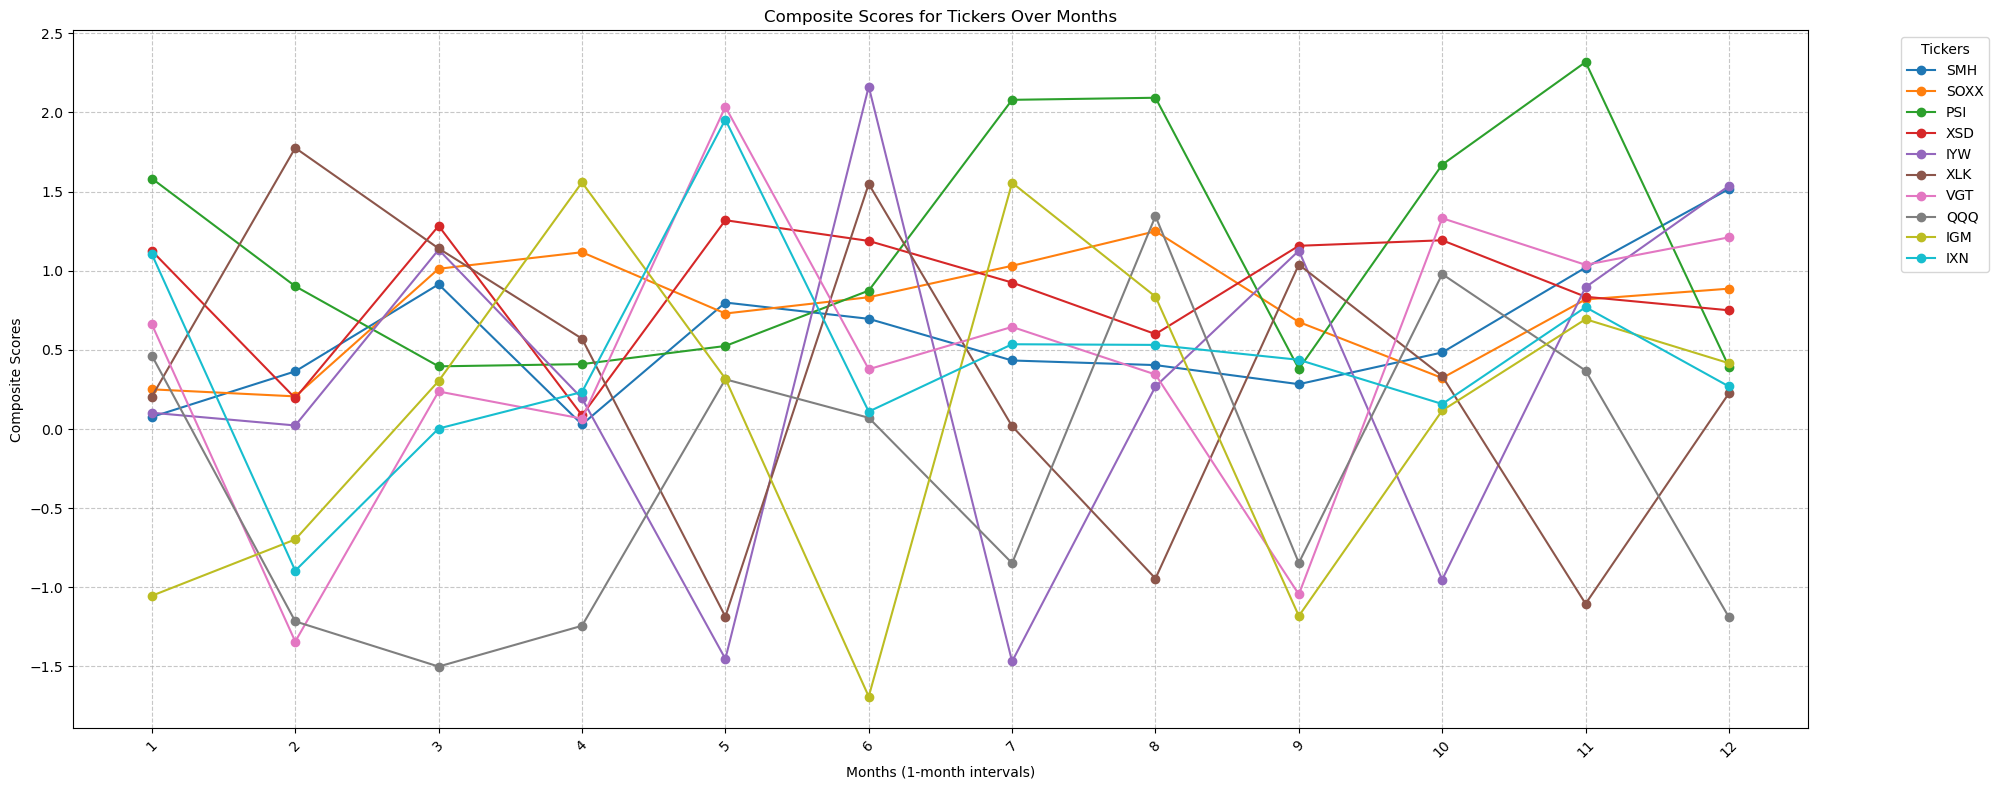

In [14]:
plot_composite_scores(scores, tickers)


### Methods for portfolio optimization of monthly horizon

In [15]:
def select_top_etfs_monthly(df, month_label, return_scores=False):
    df_sorted = df.sort_values(by='Score', ascending=False).head(2)
    if return_scores:
        return list(df_sorted.itertuples(index=False, name=None))  # Returns tuples (ETF, Score)
    return list(df_sorted['ETF'])  # Returns only ETF names

def generate_month_ranges(start_date, end_date):
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    month_ranges = []
    while start < end:
        month_start = start
        month_end = (start + timedelta(days=31)).replace(day=1) - timedelta(days=1)
        if month_end > end:
            month_end = end
        month_ranges.append((month_start.strftime('%Y-%m-%d'), month_end.strftime('%Y-%m-%d')))
        start = month_end + timedelta(days=1)
    return month_ranges

def gather_etf_data(tickers, month_ranges):
    etf_histories = {}
    for start_date, end_date in month_ranges:
        month = f"{start_date} to {end_date}"
        etf_histories[month] = {}
        for ticker in tickers:
            etf_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            etf_data.columns = etf_data.columns.get_level_values(0)
            if etf_data.empty:
                print(f"No data found for {ticker} in {month}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[month][ticker] = etf_data
    return etf_histories

def initialize_shares(top_etfs, etf_histories, month, investment_amount=50000):
    ticker_shares = {}
    first_trading_day_start = month.split(" to ")[0]
    for ticker in top_etfs:
        etf_history = etf_histories.get(month, {}).get(ticker)
        if etf_history is not None:
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            if first_trading_day not in etf_history.index:
                first_trading_day = etf_history.index[etf_history.index.searchsorted(first_trading_day)]
            price = etf_history.loc[first_trading_day, 'Close']
            num_shares = (investment_amount * 0.9975) / price
            print(f"Buy {ticker}: {num_shares:.2f} shares at {price:.2f}.")
            ticker_shares[ticker] = num_shares
        else:
            print(f"No data found for {ticker} in {month}")
    return ticker_shares

def manage_portfolio(prev_top_etfs, curr_top_etfs, prev_month, curr_month, ticker_shares, etf_histories):
    print(f"Top 2 ETFs for {prev_month}: {prev_top_etfs}")
    print(f"Top 2 ETFs for {curr_month}: {curr_top_etfs}")
    etf_histories_curr = etf_histories.get(curr_month, {})
    common_etfs = set(prev_top_etfs) & set(curr_top_etfs)
    etfs_to_sell = set(prev_top_etfs) - common_etfs
    etfs_to_buy = set(curr_top_etfs) - common_etfs
    selling_values = {}
    for etf in etfs_to_sell:
        shares = ticker_shares.pop(etf, 0)
        if shares > 0 and etf in etf_histories_curr:
            price = etf_histories_curr[etf]['Close'].iloc[0]
            selling_values[etf] = shares * price * 0.9975
            print(f"Sell {etf}: {shares:.2f} shares at {price:.2f}. Total value: {selling_values[etf]:.2f}")
    for etf_to_buy, etf_to_sell in zip(etfs_to_buy, etfs_to_sell):
        if etf_to_buy in etf_histories_curr and etf_to_sell in selling_values:
            price = etf_histories_curr[etf_to_buy]['Close'].iloc[0]
            ticker_shares[etf_to_buy] = (selling_values[etf_to_sell] * 0.9975) / price
            print(f"Buy {etf_to_buy}: {ticker_shares[etf_to_buy]:.2f} shares at {price:.2f}.")
    print(f"Updated ticker shares after {curr_month}: {ticker_shares}")
    return {etf: ticker_shares[etf] for etf in curr_top_etfs if etf in ticker_shares}



In [16]:


def calculate_smoothing(scores_dict, alpha=0.1):
    smoothed_scores = {}
    previous_values = {}
    sorted_months = sorted(scores_dict.keys(), key=lambda m: int(m))
    for month in sorted_months:
        smoothed_scores[month] = {}
        for etf, raw_score in scores_dict[month].items():
            if etf not in previous_values:
                smoothed_value = float(raw_score)
            else:
                smoothed_value = alpha * float(raw_score) + (1 - alpha) * previous_values[etf]
            smoothed_scores[month][etf] = smoothed_value
            previous_values[etf] = smoothed_value
    return smoothed_scores

def portfolio(results, return_scores=False):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results)
    
    # Store all ETF scores per month instead of only top 2 ETFs
    all_scores_per_month = {
        str(month): {
            etf: composite_scores[etf][f'composite_scores_{month}m']
            for etf in composite_scores
        }
        for month in range(1, 13)
    }
    
    return all_scores_per_month


def portfolio_optimization(results, smoothing=False):
    all_scores = portfolio(results, return_scores=True)
    print("\n--- Raw Scores Before Smoothing ---")
    for month, scores in sorted(all_scores.items(), key=lambda x: int(x[0])):
        print(f"Month {month}: {scores}")
    
    if smoothing:
        smoothed_scores = calculate_smoothing(all_scores)
        print("\n--- Smoothed Scores After Smoothing ---")
        for month, scores in sorted(smoothed_scores.items(), key=lambda x: int(x[0])):
            print(f"Month {month}: {scores}")
        
        # Use smoothed scores to select top 2 ETFs per month
        portfolios = {
            month: select_top_etfs_monthly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{month}m',
                return_scores=False
            )
            for month, scores in smoothed_scores.items()
        }
    else:
        # Select top 2 ETFs based on raw scores if no smoothing
        portfolios = {
            month: select_top_etfs_monthly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{month}m',
                return_scores=False
            )
            for month, scores in all_scores.items()
        }
    
    print("\n--- Final Portfolio Selection ---")
    for month, etfs in sorted(portfolios.items(), key=lambda x: int(x[0])):
        print(f"Month {month}: {etfs}")
    
    month_ranges = generate_month_ranges('2022-01-01', '2023-01-01')
    etf_histories = gather_etf_data(results.keys(), month_ranges)
    ticker_shares = {}
    ticker_shares_per_month = {}
    
    for i, month_range in enumerate(etf_histories.keys()):
        month_index = str(i + 1)
        top_etfs = portfolios.get(month_index, [])
        if not top_etfs:
            print(f"Warning: No ETFs selected for {month_range}. Skipping trading.")
            continue
        if i == 0:
            ticker_shares = initialize_shares(top_etfs, etf_histories, month_range)
        else:
            prev_month_index = str(i)
            prev_top_etfs = portfolios.get(prev_month_index, [])
            ticker_shares = manage_portfolio(
                prev_top_etfs,
                top_etfs,
                list(etf_histories.keys())[i - 1],
                month_range,
                ticker_shares,
                etf_histories
            )
        ticker_shares_per_month[month_range] = ticker_shares.copy()
    
    first_trading_day_13m = '2023-01-01'
    month_12_range = list(ticker_shares_per_month.keys())[-1]
    month_13_start = first_trading_day_13m
    month_13_end = '2023-01-06'
    etf_values_13m = {}
    
    if month_12_range in ticker_shares_per_month:
        ticker_shares_12m = ticker_shares_per_month[month_12_range]
        for ticker, shares in ticker_shares_12m.items():
            data = yf.download(ticker, start=month_13_start, end=month_13_end)
            data.columns = data.columns.get_level_values(0)
            if not data.empty:
                closing_price_13m = data['Close'].iloc[0]
                total_value = shares * closing_price_13m
                etf_values_13m[ticker] = total_value
    
    total_portfolio_value = sum(etf_values_13m.values()) if etf_values_13m else 0
    return ticker_shares_per_month, total_portfolio_value


### Portfolio Optimization with and without smoothing enabled

In [17]:

portfolios, final_value = portfolio_optimization(results, smoothing=True)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Month 1: {'SMH': 0.07637305155847529, 'SOXX': 0.25076423714423773, 'PSI': 1.582615583667301, 'XSD': 1.1251119501918818, 'IYW': 0.10297660675607323, 'XLK': 0.20514609924726393, 'VGT': 0.6607880747918589, 'QQQ': 0.46355431953215376, 'IGM': -1.0531366852751773, 'IXN': 1.1041710550698012}
Month 2: {'SMH': 0.36437980325726377, 'SOXX': 0.20634492572505306, 'PSI': 0.9020580180952508, 'XSD': 0.1947197901712067, 'IYW': 0.02255811099360757, 'XLK': 1.7759183341706806, 'VGT': -1.3424352828775974, 'QQQ': -1.2150900102167788, 'IGM': -0.6974161689769687, 'IXN': -0.8947042947739734}
Month 3: {'SMH': 0.91407056782477, 'SOXX': 1.0124136079413277, 'PSI': 0.39601782596131935, 'XSD': 1.28359217049901, 'IYW': 1.1331376127459323, 'XLK': 1.141004180182416, 'VGT': 0.2372267475714075, 'QQQ': -1.500464759031994, 'IGM': 0.3032062724671645, 'IXN': 0.0031872004505057875}
Month 4: {'SMH': 0.028987190472578746, 'SOXX': 1.1169157666887009, 'PSI': 0.4100603274176084, 'XSD': 0.086554

[*********************100%***********************]  1 of 1 completed

Buy PSI: 970.92 shares at 51.37.
Buy XSD: 202.97 shares at 245.72.
Top 2 ETFs for 2022-01-01 to 2022-01-31: ['PSI', 'XSD']
Top 2 ETFs for 2022-02-01 to 2022-02-28: ['PSI', 'XSD']
Updated ticker shares after 2022-02-01 to 2022-02-28: {'PSI': 970.9237476507451, 'XSD': 202.97455167610394}
Top 2 ETFs for 2022-02-01 to 2022-02-28: ['PSI', 'XSD']
Top 2 ETFs for 2022-03-01 to 2022-03-31: ['PSI', 'XSD']
Updated ticker shares after 2022-03-01 to 2022-03-31: {'PSI': 970.9237476507451, 'XSD': 202.97455167610394}
Top 2 ETFs for 2022-03-01 to 2022-03-31: ['PSI', 'XSD']
Top 2 ETFs for 2022-04-01 to 2022-04-30: ['PSI', 'XSD']
Updated ticker shares after 2022-04-01 to 2022-04-30: {'PSI': 970.9237476507451, 'XSD': 202.97455167610394}
Top 2 ETFs for 2022-04-01 to 2022-04-30: ['PSI', 'XSD']
Top 2 ETFs for 2022-05-01 to 2022-05-31: ['PSI', 'XSD']
Updated ticker shares after 2022-05-01 to 2022-05-31: {'PSI': 970.9237476507451, 'XSD': 202.97455167610394}
Top 2 ETFs for 2022-05-01 to 2022-05-31: ['PSI', 'XSD


[*********************100%***********************]  1 of 1 completed

Final Portfolio Value: 65170.85


In [18]:

portfolios, final_value = portfolio_optimization(results, smoothing=False)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Month 1: {'SMH': 0.07637305155847529, 'SOXX': 0.25076423714423773, 'PSI': 1.582615583667301, 'XSD': 1.1251119501918818, 'IYW': 0.10297660675607323, 'XLK': 0.20514609924726393, 'VGT': 0.6607880747918589, 'QQQ': 0.46355431953215376, 'IGM': -1.0531366852751773, 'IXN': 1.1041710550698012}
Month 2: {'SMH': 0.36437980325726377, 'SOXX': 0.20634492572505306, 'PSI': 0.9020580180952508, 'XSD': 0.1947197901712067, 'IYW': 0.02255811099360757, 'XLK': 1.7759183341706806, 'VGT': -1.3424352828775974, 'QQQ': -1.2150900102167788, 'IGM': -0.6974161689769687, 'IXN': -0.8947042947739734}
Month 3: {'SMH': 0.91407056782477, 'SOXX': 1.0124136079413277, 'PSI': 0.39601782596131935, 'XSD': 1.28359217049901, 'IYW': 1.1331376127459323, 'XLK': 1.141004180182416, 'VGT': 0.2372267475714075, 'QQQ': -1.500464759031994, 'IGM': 0.3032062724671645, 'IXN': 0.0031872004505057875}
Month 4: {'SMH': 0.028987190472578746, 'SOXX': 1.1169157666887009, 'PSI': 0.4100603274176084, 'XSD': 0.086554

[*********************100%***********************]  1 of 1 completed

Buy PSI: 970.92 shares at 51.37.
Buy XSD: 202.97 shares at 245.72.
Top 2 ETFs for 2022-01-01 to 2022-01-31: ['PSI', 'XSD']
Top 2 ETFs for 2022-02-01 to 2022-02-28: ['XLK', 'PSI']
Sell XSD: 202.97 shares at 204.08. Total value: 41319.72
Buy XLK: 260.76 shares at 158.06.
Updated ticker shares after 2022-02-01 to 2022-02-28: {'PSI': 970.9237476507451, 'XLK': 260.7570785804795}
Top 2 ETFs for 2022-02-01 to 2022-02-28: ['XLK', 'PSI']
Top 2 ETFs for 2022-03-01 to 2022-03-31: ['XSD', 'XLK']
Sell PSI: 970.92 shares at 41.24. Total value: 39940.62
Buy XSD: 202.96 shares at 196.30.
Updated ticker shares after 2022-03-01 to 2022-03-31: {'XLK': 260.7570785804795, 'XSD': 202.9632767987787}
Top 2 ETFs for 2022-03-01 to 2022-03-31: ['XSD', 'XLK']
Top 2 ETFs for 2022-04-01 to 2022-04-30: ['IGM', 'SOXX']
Sell XLK: 260.76 shares at 154.52. Total value: 40192.51
Sell XSD: 202.96 shares at 201.19. Total value: 40732.14
Buy IGM: 627.63 shares at 63.88.
Buy SOXX: 269.74 shares at 150.63.
Updated ticker shar


[*********************100%***********************]  1 of 1 completed

Final Portfolio Value: 62713.48


### Compute the scores for weekly horizons and plot the scores

In [19]:

def compute_risk_metrics(results):
    risk_metrics_results = {}
    for ticker, data in results.items():
        risk_metrics_results[ticker] = {}
        # Change range(1, 13) to range(1, 53) and month -> week
        for week in range(1, 53):
            # Change 'monthly_forecast_results' to 'weekly_forecast_results' 
            # and '{month}m' to '{week}w'
            future_predictions = data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']
            
            sharpe = calculate_sharpe_ratio(future_predictions)
            rachev = calculate_rachev_ratio(future_predictions)
            volatility_clustering = calculate_volatility_clustering(future_predictions)
            sortino = calculate_sortino_ratio(future_predictions)
            
            # Rename 'risk_metrics_{month}m' to 'risk_metrics_{week}w'
            risk_metrics_results[ticker][f'risk_metrics_{week}w'] = {
                'Sharpe Ratio': sharpe,
                'Rachev Ratio': rachev,
                'Volatility Clustering': volatility_clustering,
                'Sortino Ratio': sortino
            }
    return risk_metrics_results
###
def compute_composite_scores(results, risk_metrics_results):
    composite_scores = {}
    
    for week in range(1, 53):
        forecasted_values = {
            ticker: data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']
            for ticker, data in results.items()
        }

        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{week}w']
            
            score, optimized_weights = calculate_composite_score_optimized(
                forecasted_values[ticker], risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                np.mean([m[f'risk_metrics_{week}w']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{week}w']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{week}w']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{week}w']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Volatility Clustering'] for m in risk_metrics_results.values()])
            )
            
            composite_scores.setdefault(ticker, {})[f'composite_scores_{week}w'] = score
    
    return composite_scores


In [20]:
def scores_weekly(results, return_scores=False):
    """
    Compute risk metrics and composite scores on a weekly basis.
    Return a dictionary of all ETF scores per week (rather than just the top 2).
    """
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results)
    
    # Collect all ETF scores per week
    # Instead of composite_score_{month}m, we use composite_score_{week}w
    all_scores_per_week = {
        str(week): {
            etf: composite_scores[etf][f'composite_scores_{week}w']
            for etf in composite_scores
        }
        for week in range(1, 53)  # 1 to 52 for weeks in a year, adjust as needed
    }
    
    return all_scores_per_week
import matplotlib.pyplot as plt

def plot_composite_scores(scores, tickers):
    """
    Plots composite scores for given tickers over time with 4-week intervals on the x-axis.

    Parameters:
    - scores (dict): A dictionary with weeks as keys and another dictionary of ticker scores as values.
                     Example: {"Week 1": {"SMH": 2.5, "SOXX": 1.3}, "Week 2": {"SMH": 2.7, "SOXX": 1.0}}
    - tickers (list): A list of ticker symbols to plot. Example: ["SMH", "SOXX"]
    """
    # Extract weeks
    weeks = list(scores.keys())

    # Extract scores for each ticker
    ticker_scores = {ticker: [scores[week].get(ticker, None) for week in weeks] for ticker in tickers}

    # Plot scores for each ticker
    plt.figure(figsize=(30, 14))
    for ticker in tickers:
        if ticker in ticker_scores:
            plt.plot(weeks, ticker_scores[ticker], marker='o', label=ticker)

    # Setting 4-week interval for x-axis labels
    plt.xticks(ticks=range(0, len(weeks), 4), labels=weeks[::4], rotation=45)

    plt.title("Composite Scoares for Tickers Over Weeks")
    plt.xlabel("Weeks (4-week intervals)")
    plt.ylabel("Composite Scores")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title="Tickers", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
scores=scores_weekly(results,return_scores=False)



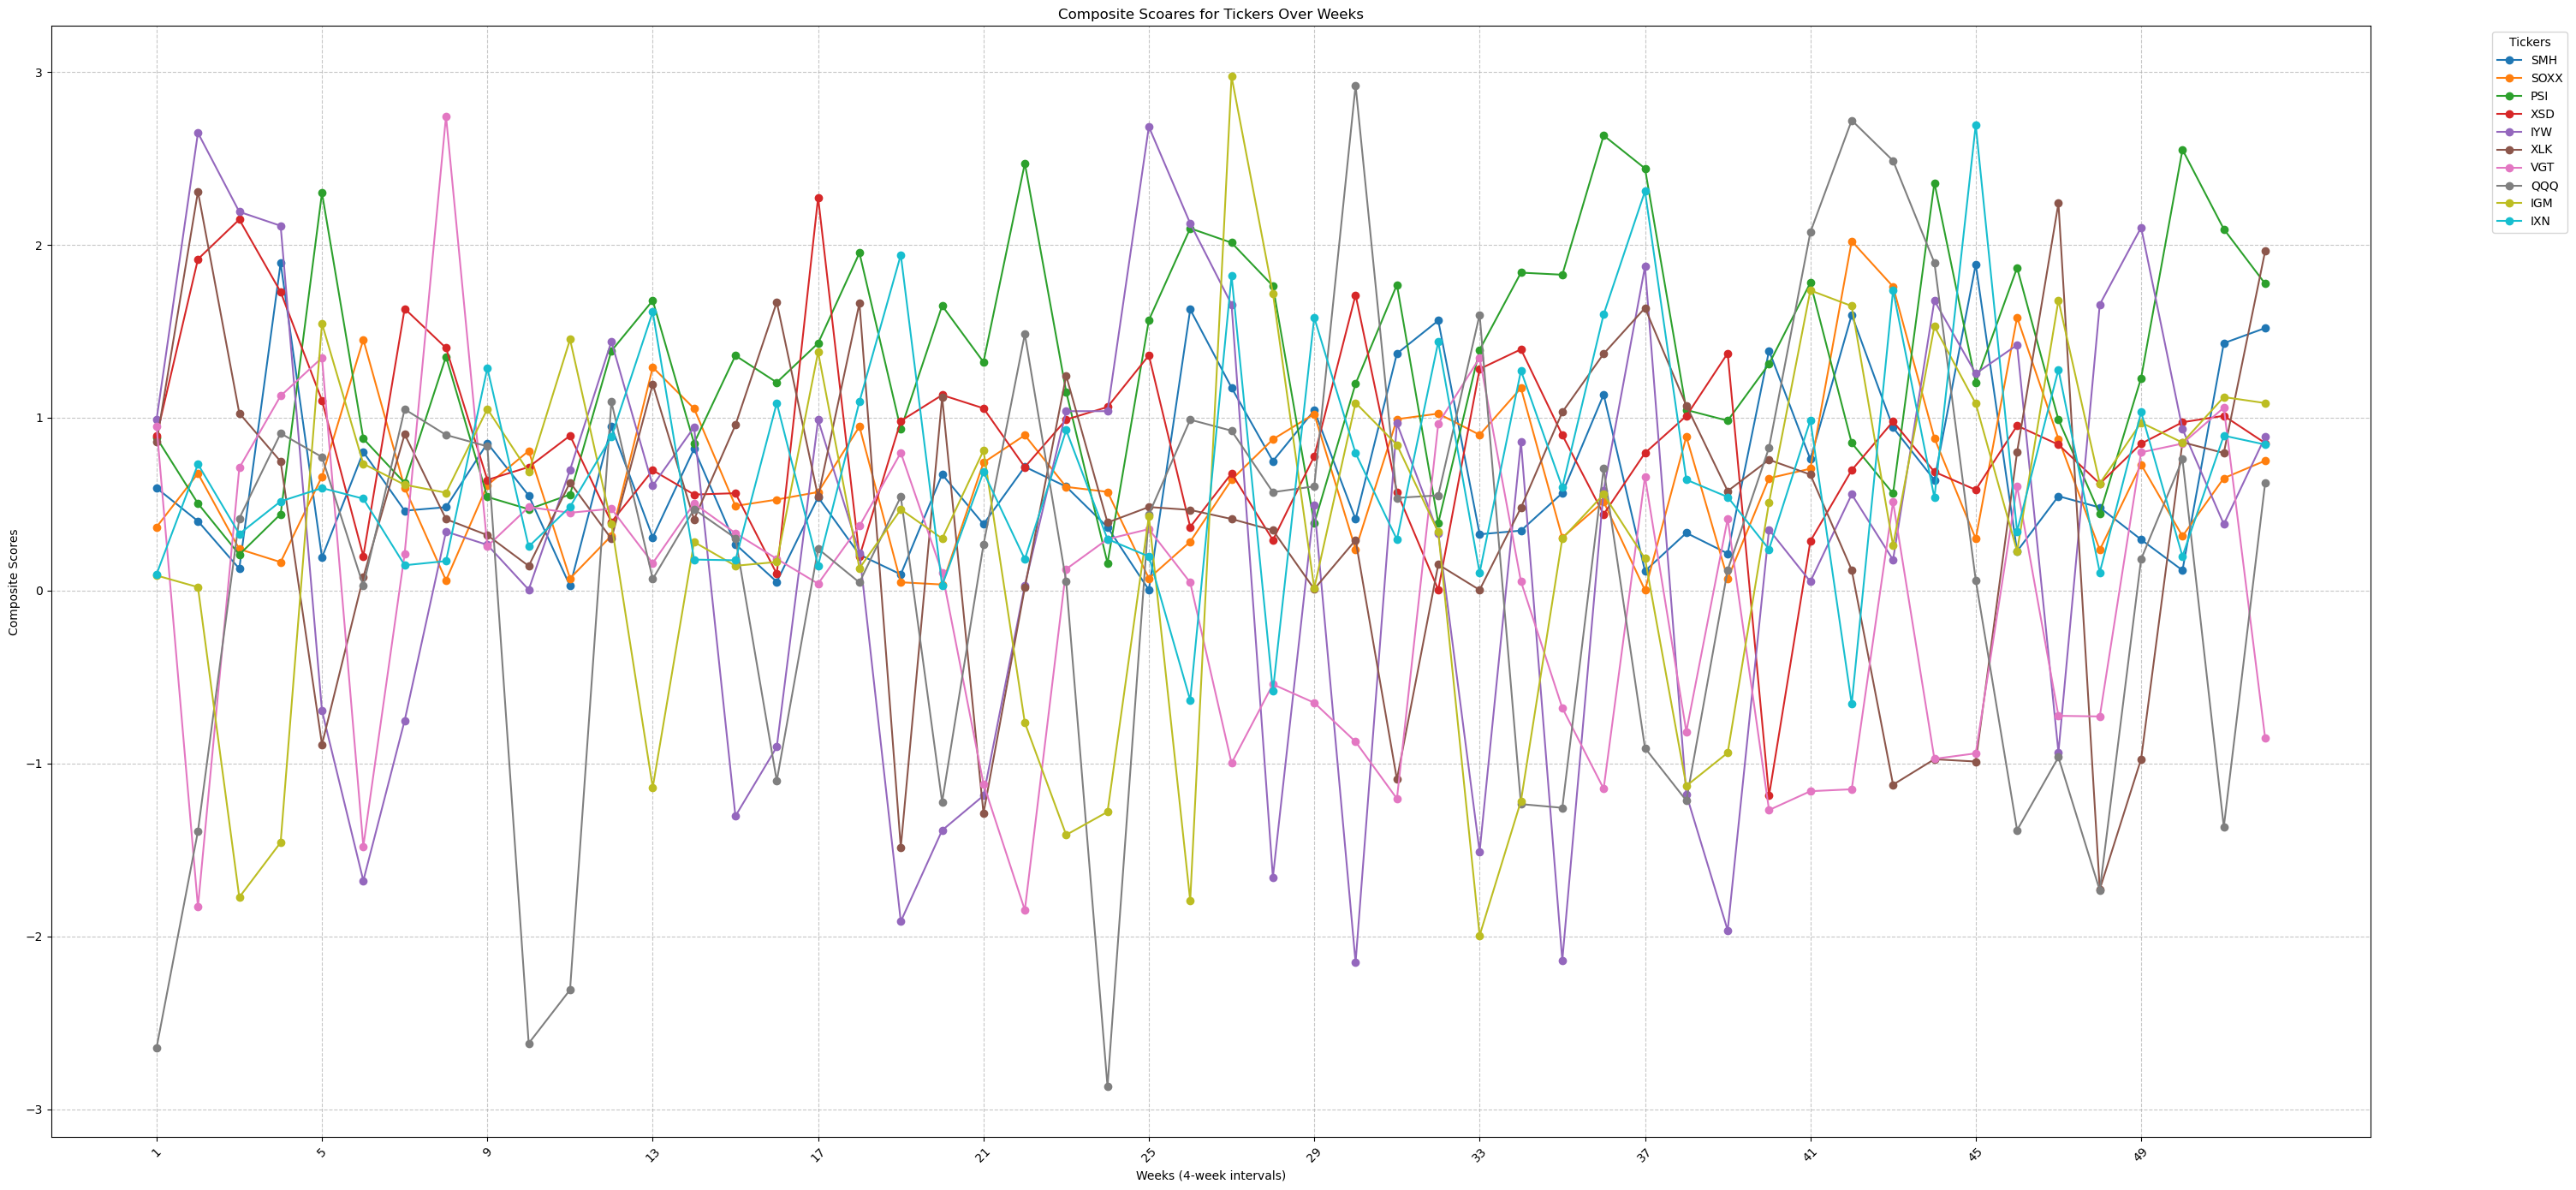

In [21]:
plot_composite_scores(scores, tickers)


### Methods for portfolio optimization of weekly horizon

In [22]:

def select_top_etfs_weekly(df, week_label, return_scores=False):
    """
    Select the top 2 ETFs based on 'Score' for the given week_label.
    """
    df_sorted = df.sort_values(by='Score', ascending=False).head(2)
    if return_scores:
        # Returns list of tuples (ETF, Score)
        return list(df_sorted.itertuples(index=False, name=None))
    # Returns only ETF names
    return list(df_sorted['ETF'])

def generate_week_ranges(start_date, end_date):
    """
    Generate a list of weekly date ranges from start_date to end_date.
    Each range is 7 days long (e.g., Monday to Sunday).
    """
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    week_ranges = []
    
    while start < end:
        week_start = start
        # Each period is one week long (7 days)
        week_end = start + timedelta(days=6)
        # If the next 7-day block goes beyond end, truncate to end
        if week_end > end:
            week_end = end
        week_ranges.append((week_start.strftime('%Y-%m-%d'), week_end.strftime('%Y-%m-%d')))
        
        # Move to the day after week_end to start the next week
        start = week_end + timedelta(days=1)
    
    return week_ranges

def gather_etf_data_weekly(tickers, week_ranges):
    """
    Download weekly ETF data for the specified tickers over the given weekly ranges.
    Returns a dictionary keyed by 'start_date to end_date', each containing data per ticker.
    """
    etf_histories = {}
    for start_date, end_date in week_ranges:
        week = f"{start_date} to {end_date}"
        etf_histories[week] = {}
        for ticker in tickers:
            etf_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            etf_data.columns = etf_data.columns.get_level_values(0)

            if etf_data.empty:
                print(f"No data found for {ticker} in {week}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[week][ticker] = etf_data
    return etf_histories

def initialize_shares(top_etfs, etf_histories, week, investment_amount=50000):
    """
    Initialize shares for the top ETFs at the beginning of a given 'week'.
    """
    ticker_shares = {}
    # The 'week' string is in the format: "yyyy-mm-dd to yyyy-mm-dd"
    first_trading_day_start = week.split(" to ")[0]
    
    for ticker in top_etfs:
        etf_history = etf_histories.get(week, {}).get(ticker)
        if etf_history is not None and not etf_history.empty:
            # Move one business day forward from the week start
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            # If this exact date isn't in the index, find the nearest future trading day
            if first_trading_day not in etf_history.index:
                idx_pos = etf_history.index.searchsorted(first_trading_day)
                if idx_pos < len(etf_history.index):
                    first_trading_day = etf_history.index[idx_pos]
                else:
                    print(f"No valid trading day found for {ticker} in {week}")
                    continue
            
            price = etf_history.loc[first_trading_day, 'Close']
            num_shares = (investment_amount * 0.9975) / price  # small friction cost (0.25%)
            print(f"Buy {ticker}: {num_shares:.2f} shares at {price:.2f}.")
            ticker_shares[ticker] = num_shares
        else:
            print(f"No data found for {ticker} in {week}")
    return ticker_shares

def manage_portfolio(prev_top_etfs, curr_top_etfs, prev_week, curr_week, ticker_shares, etf_histories):
    """
    Manage the transition from prev_week's top ETFs to curr_week's top ETFs,
    selling ETFs no longer in the top 2, and buying newly selected ETFs.
    """
    print(f"Top 2 ETFs for {prev_week}: {prev_top_etfs}")
    print(f"Top 2 ETFs for {curr_week}: {curr_top_etfs}")
    
    etf_histories_curr = etf_histories.get(curr_week, {})
    common_etfs = set(prev_top_etfs) & set(curr_top_etfs)
    etfs_to_sell = set(prev_top_etfs) - common_etfs
    etfs_to_buy = set(curr_top_etfs) - common_etfs

    selling_values = {}
    for etf in etfs_to_sell:
        shares = ticker_shares.pop(etf, 0)
        if shares > 0 and etf in etf_histories_curr and not etf_histories_curr[etf].empty:
            # Use the first available Close price in the new week to sell
            price = etf_histories_curr[etf]['Close'].iloc[0]
            selling_values[etf] = shares * price * 0.9975
            print(f"Sell {etf}: {shares:.2f} shares at {price:.2f}. Total value: {selling_values[etf]:.2f}")

    # Use zipped pairs to buy new ETFs using the proceeds from sold ETFs
    for etf_to_buy, etf_to_sell in zip(etfs_to_buy, etfs_to_sell):
        if etf_to_buy in etf_histories_curr and etf_to_sell in selling_values:
            price = etf_histories_curr[etf_to_buy]['Close'].iloc[0]
            ticker_shares[etf_to_buy] = (selling_values[etf_to_sell] * 0.9975) / price
            print(f"Buy {etf_to_buy}: {ticker_shares[etf_to_buy]:.2f} shares at {price:.2f}.")

    print(f"Updated ticker shares after {curr_week}: {ticker_shares}")
    # Return only shares for the newly selected top ETFs
    return {etf: ticker_shares[etf] for etf in curr_top_etfs if etf in ticker_shares}




In [23]:

def calculate_smoothing(scores_dict, alpha=0.1):
    """
    Apply exponential smoothing to a dictionary of dictionaries containing scores.
    Keys at the top level are weeks (as strings), and values are {etf: raw_score}.
    """
    smoothed_scores = {}
    previous_values = {}
    # Sort by the numeric value of the week string (e.g., '1', '2', ..., '52')
    sorted_weeks = sorted(scores_dict.keys(), key=lambda w: int(w))
    
    for week in sorted_weeks:
        smoothed_scores[week] = {}
        for etf, raw_score in scores_dict[week].items():
            if etf not in previous_values:
                # First time seeing this ETF, just take the raw score
                smoothed_value = float(raw_score)
            else:
                # Exponential smoothing
                smoothed_value = alpha * float(raw_score) + (1 - alpha) * previous_values[etf]
            smoothed_scores[week][etf] = smoothed_value
            previous_values[etf] = smoothed_value
    
    return smoothed_scores

def portfolio_weekly(results, return_scores=False):
    """
    Compute risk metrics and composite scores on a weekly basis.
    Return a dictionary of all ETF scores per week (rather than just the top 2).
    """
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results)
    
    # Collect all ETF scores per week
    # Instead of composite_score_{month}m, we use composite_score_{week}w
    all_scores_per_week = {
        str(week): {
            etf: composite_scores[etf][f'composite_scores_{week}w']
            for etf in composite_scores
        }
        for week in range(1, 53)  # 1 to 52 for weeks in a year, adjust as needed
    }
    
    return all_scores_per_week

def portfolio_optimization_weekly(results, smoothing=False):
    """
    High-level function to:
      - Get all raw weekly scores
      - Optionally apply smoothing
      - Select top ETFs each week
      - Manage portfolio transitions through the weeks
      - Calculate final portfolio value after a certain 'week 53' period or next horizon
    """
    # 1) Get all raw weekly scores
    all_scores = portfolio_weekly(results, return_scores=True)
    
    print("\n--- Raw Scores Before Smoothing ---")
    for week, scores in sorted(all_scores.items(), key=lambda x: int(x[0])):
        print(f"Week {week}: {scores}")
    
    # 2) Optionally apply smoothing
    if smoothing:
        smoothed_scores = calculate_smoothing(all_scores)
        print("\n--- Smoothed Scores After Smoothing ---")
        for week, scores in sorted(smoothed_scores.items(), key=lambda x: int(x[0])):
            print(f"Week {week}: {scores}")
        
        # Select top 2 ETFs based on smoothed scores
        portfolios = {
            week: select_top_etfs_weekly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{week}w',
                return_scores=False
            )
            for week, scores in smoothed_scores.items()
        }
    else:
        # Select top 2 ETFs based on raw scores
        portfolios = {
            week: select_top_etfs_weekly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{week}w',
                return_scores=False
            )
            for week, scores in all_scores.items()
        }
    
    print("\n--- Final Portfolio Selection ---")
    for week, etfs in sorted(portfolios.items(), key=lambda x: int(x[0])):
        print(f"Week {week}: {etfs}")
    
    # 3) Gather weekly data for the actual buy/sell simulation
    #    Replace this range with your desired start/end for weekly intervals
    week_ranges = generate_week_ranges('2022-01-01', '2022-12-31')
    etf_histories = gather_etf_data_weekly(results.keys(), week_ranges)
    
    # Keep track of shares after each week
    ticker_shares = {}
    ticker_shares_per_week = {}
    
    # 4) Loop through the weeks in etf_histories
    for i, week_range in enumerate(etf_histories.keys()):
        week_index = str(i + 1)  # '1', '2', '3', ...
        top_etfs = portfolios.get(week_index, [])
        
        if not top_etfs:
            print(f"Warning: No ETFs selected for {week_range}. Skipping trading.")
            continue
        
        if i == 0:
            # First week: initialize shares
            ticker_shares = initialize_shares(top_etfs, etf_histories, week_range)
        else:
            # Manage portfolio transitions from previous week
            prev_week_index = str(i)
            prev_top_etfs = portfolios.get(prev_week_index, [])
            ticker_shares = manage_portfolio(
                prev_top_etfs,
                top_etfs,
                list(etf_histories.keys())[i - 1],
                week_range,
                ticker_shares,
                etf_histories
            )
        
        ticker_shares_per_week[week_range] = ticker_shares.copy()
    
    # 5) Simulate final valuation after "Week 53" or any next horizon
    #    For illustration, let's say it's a few days into 2023.
    first_trading_day_53w = '2023-01-01'
    week_52_range = list(ticker_shares_per_week.keys())[-1] if ticker_shares_per_week else None
    
    # We can define a short window for the next week:
    week_53_start = first_trading_day_53w
    week_53_end = '2023-01-06'
    etf_values_53w = {}
    
    if week_52_range and week_52_range in ticker_shares_per_week:
        ticker_shares_52w = ticker_shares_per_week[week_52_range]
        for ticker, shares in ticker_shares_52w.items():
            data = yf.download(ticker, start=week_53_start, end=week_53_end, progress=False)
            data.columns = data.columns.get_level_values(0)
            if not data.empty:
                closing_price_53w = data['Close'].iloc[0]
                total_value = shares * closing_price_53w
                etf_values_53w[ticker] = total_value
    
    total_portfolio_value = sum(etf_values_53w.values()) if etf_values_53w else 0
    
    return ticker_shares_per_week, total_portfolio_value


### Portfolio Optimization with and without smoothing enabled

In [24]:

portfolios, final_value = portfolio_optimization_weekly(results, smoothing=True)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Week 1: {'SMH': 0.5934899405728085, 'SOXX': 0.36827068118777434, 'PSI': 0.8840502352753525, 'XSD': 0.8955964947236165, 'IYW': 0.9914006587670452, 'XLK': 0.8597977673394736, 'VGT': 0.9486729366562842, 'QQQ': -2.64365768168317, 'IGM': 0.08768995997167427, 'IXN': 0.09581397392989009}
Week 2: {'SMH': 0.40211167068807735, 'SOXX': 0.678092745088489, 'PSI': 0.5042777831139936, 'XSD': 1.9176871874819068, 'IYW': 2.6483907796479893, 'XLK': 2.3088983558060185, 'VGT': -1.8292385284345756, 'QQQ': -1.3914224283557428, 'IGM': 0.020157781129453576, 'IXN': 0.7314503012089801}
Week 3: {'SMH': 0.12700894469734703, 'SOXX': 0.24032681532753383, 'PSI': 0.20846352999379478, 'XSD': 2.1470923523189773, 'IYW': 2.1916011975808654, 'XLK': 1.026524992617645, 'VGT': 0.7104042289590775, 'QQQ': 0.4179968673910053, 'IGM': -1.7739168353401535, 'IXN': 0.32794881510816076}
Week 4: {'SMH': 1.8958526293316509, 'SOXX': 0.1650686227249414, 'PSI': 0.4427657019848017, 'XSD': 1.7278658901442

Buy IYW: 436.49 shares at 114.26.
Buy VGT: 110.53 shares at 451.23.
Top 2 ETFs for 2022-01-01 to 2022-01-07: ['IYW', 'VGT']
Top 2 ETFs for 2022-01-08 to 2022-01-14: ['IYW', 'XLK']
Sell VGT: 110.53 shares at 425.17. Total value: 46877.29
Buy XLK: 289.47 shares at 161.54.
Updated ticker shares after 2022-01-08 to 2022-01-14: {'IYW': 436.4912232908348, 'XLK': 289.4657890066424}
Top 2 ETFs for 2022-01-08 to 2022-01-14: ['IYW', 'XLK']
Top 2 ETFs for 2022-01-15 to 2022-01-21: ['IYW', 'XSD']
Sell XLK: 289.47 shares at 157.47. Total value: 45468.41
Buy XSD: 211.90 shares at 214.03.
Updated ticker shares after 2022-01-15 to 2022-01-21: {'IYW': 436.4912232908348, 'XSD': 211.90488718197057}
Top 2 ETFs for 2022-01-15 to 2022-01-21: ['IYW', 'XSD']
Top 2 ETFs for 2022-01-22 to 2022-01-28: ['IYW', 'XSD']
Updated ticker shares after 2022-01-22 to 2022-01-28: {'IYW': 436.4912232908348, 'XSD': 211.90488718197057}
Top 2 ETFs for 2022-01-22 to 2022-01-28: ['IYW', 'XSD']
Top 2 ETFs for 2022-01-29 to 2022-0

Final Portfolio Value: 68870.48


In [25]:

portfolios, final_value = portfolio_optimization_weekly(results, smoothing=False)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Week 1: {'SMH': 0.5934899405728085, 'SOXX': 0.36827068118777434, 'PSI': 0.8840502352753525, 'XSD': 0.8955964947236165, 'IYW': 0.9914006587670452, 'XLK': 0.8597977673394736, 'VGT': 0.9486729366562842, 'QQQ': -2.64365768168317, 'IGM': 0.08768995997167427, 'IXN': 0.09581397392989009}
Week 2: {'SMH': 0.40211167068807735, 'SOXX': 0.678092745088489, 'PSI': 0.5042777831139936, 'XSD': 1.9176871874819068, 'IYW': 2.6483907796479893, 'XLK': 2.3088983558060185, 'VGT': -1.8292385284345756, 'QQQ': -1.3914224283557428, 'IGM': 0.020157781129453576, 'IXN': 0.7314503012089801}
Week 3: {'SMH': 0.12700894469734703, 'SOXX': 0.24032681532753383, 'PSI': 0.20846352999379478, 'XSD': 2.1470923523189773, 'IYW': 2.1916011975808654, 'XLK': 1.026524992617645, 'VGT': 0.7104042289590775, 'QQQ': 0.4179968673910053, 'IGM': -1.7739168353401535, 'IXN': 0.32794881510816076}
Week 4: {'SMH': 1.8958526293316509, 'SOXX': 0.1650686227249414, 'PSI': 0.4427657019848017, 'XSD': 1.7278658901442

Buy IYW: 436.49 shares at 114.26.
Buy VGT: 110.53 shares at 451.23.
Top 2 ETFs for 2022-01-01 to 2022-01-07: ['IYW', 'VGT']
Top 2 ETFs for 2022-01-08 to 2022-01-14: ['IYW', 'XLK']
Sell VGT: 110.53 shares at 425.17. Total value: 46877.28
Buy XLK: 289.47 shares at 161.54.
Updated ticker shares after 2022-01-08 to 2022-01-14: {'IYW': 436.4911941462302, 'XLK': 289.46571354438356}
Top 2 ETFs for 2022-01-08 to 2022-01-14: ['IYW', 'XLK']
Top 2 ETFs for 2022-01-15 to 2022-01-21: ['IYW', 'XSD']
Sell XLK: 289.47 shares at 157.47. Total value: 45468.40
Buy XSD: 211.90 shares at 214.03.
Updated ticker shares after 2022-01-15 to 2022-01-21: {'IYW': 436.4911941462302, 'XSD': 211.9048772605607}
Top 2 ETFs for 2022-01-15 to 2022-01-21: ['IYW', 'XSD']
Top 2 ETFs for 2022-01-22 to 2022-01-28: ['IYW', 'SMH']
Sell XSD: 211.90 shares at 200.12. Total value: 42301.23
Buy SMH: 313.36 shares at 134.66.
Updated ticker shares after 2022-01-22 to 2022-01-28: {'IYW': 436.4911941462302, 'SMH': 313.35779592441224}


Final Portfolio Value: 61541.49
